# Customer Segmentation Using Cohort, RFM and Clustering Analyses

## Outline
    [x] Data diambil dari database reporting untuk brand A
    [x] Filter
        [x] Channel group crm2crm
        [x] periode transaksi 12 bulan terakhir

Analisis RFM (Recency, Frequency, Monetary) merupakan pendekatan yang digunakan oleh bisnis untuk memahami dan mengelompokkan pelanggan berdasarkan tiga dimensi utama:

1.  Recency: Seberapa baru pelanggan melakukan transaksi; semakin kecil nilainya, semakin baik.
2.  Frequency: Seberapa sering pelanggan melakukan transaksi dalam periode waktu tertentu; semakin besar nilainya, semakin baik.
3.  Monetary: Seberapa banyak uang yang dihabiskan oleh pelanggan dalam periode waktu tertentu; semakin besar nilainya, semakin baik.

Pada kasus pelanggan brand A, klaster dibentuk menggunakan algoritma KMeans dengan jumlah klaster optimum sebanyak 3 (ditentukan melalui metode elbow). Setiap klaster memiliki karakteristik sebagai berikut:

1.  Klaster 0 (frequency dan monetary rendah namun recency yang tinggi) terdiri dari customer yang tergolong pasif (hanya mencoba) dan memiliki potensi besar untuk churn. Oleh karena itu, diperlukan strategi marketing yang bertujuan untuk mencegah customer ini agar tidak churn.

2.  Klaster 1 (frequency, monetary, dan recency yang tinggi) terdiri dari customer dengan nilai frequency dan monetary yang tinggi. Oleh karena itu, diperlukan strategi marketing yang bertujuan untuk mempertahankan loyalitas customer ini dan meningkatkan interaksi mereka dengan brand A.

3.  Klaster 2 (frequency, monetary, dan recency yang rendah) terdiri dari customer baru yang baru mencoba produk brand A. Hal ini dapat dilihat dari nilai recency dan frekuensi yang rendah. Oleh karena itu, diperlukan strategi marketing khusus untuk menjaga customer baru agar tetap menggunakan brand A.

Klaster yang dihasilkan melalui metode KMeans dianggap lebih unggul dibandingkan metode persentil karena klaster tersebut memiliki nilai centroid (rata-rata variabel dari setiap klaster) yang lebih berbeda di antara klasternya.

## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#import missingno as msno
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
import warnings
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [2]:
# set plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # improves resolutions of inline plots
sns.set_theme(style='white')
sns.set_style("ticks")
sns.set_context("paper")
rcParams['axes.titlepad'] = 12    # set a distance between title and plot

In [3]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pyodbc

# Konfigurasi koneksi ke SQL Server
server = 'server'
database = 'database'
username = 'username'
password = 'password'

# Buat koneksi
connection = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [7]:
query = """
SELECT LEFT(KontakID, 5) + REPLICATE('X', (LEN(KontakID)-10)) + RIGHT(KontakID, 5) CustomerID,
	LEFT(NomorHandphone, 4) + REPLICATE('X', (LEN(KontakID)-4)) NomorHandphone,
	LEFT(IDTrx, (LEN(IDTrx)-7)) + REPLICATE('X', 7) InvoiceNo,
	Qty Quantity,
	PurchasedDate InvoiceDate,
	Amount/Qty UnitPrice
FROM vw_ctd WITH(NOLOCK)
WHERE PurchasedDate >= DATEADD(MONTH, -12, GETDATE())
	AND Brand = 'A'
	AND Filter1 = 'Kondisi1'
"""
data_raw= pd.read_sql(query, connection)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# loading the csv data file as dataframe
#data_raw.to_excel(r'D:/Roudhotul Maemanah/Portofolio/RFM/Data RFM Brand A.csv')
#data_raw.to_csv(r'D:/Roudhotul Maemanah/Portofolio/RFM/Data RFM Brand A.csv')

# Memanggil Data
#data_raw = pd.read_excel(r'D:/Roudhotul Maemanah/Portofolio/RFM/Data RFM Brand A.csv')
#data_raw = pd.read_csv(r'/content/drive/MyDrive/CRM/RFM/Data RFM Brand A.csv')
#data_raw = data_raw.drop(['Unnamed: 0'], axis=1)

data_raw.head()

CustomerID NomorHandphone                        InvoiceNo  Quantity  \
0  1909-XX98638   0877XXXXXXXX  KD43-369-301294U42401011XXXXXXX       1.0   
1  1509-XX57585   0857XXXXXXXX  Q271-400-21035MU62304021XXXXXXX       1.0   
2  1602-XX00010   0812XXXXXXXX  P635-129-2003KMKZ2304011XXXXXXX       1.0   
3  1908-XXK3553   0812XXXXXXXX  B867-212-2503V8V62303301XXXXXXX       1.0   
4  2112-XXG9914   0819XXXXXXXX  I503-109-1903TC652303310XXXXXXX       1.0   

  InvoiceDate  UnitPrice  
0  2023-12-30    46300.0  
1  2023-03-21    83900.0  
2  2023-03-20    46200.0  
3  2023-03-25    44500.0  
4  2023-03-19    46300.0

In [9]:
data_raw.shape

(72960, 6)

In [10]:
df = data_raw.copy()

## Data Profiling & Cleaning

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72960 entries, 0 to 72959
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      72960 non-null  object 
 1   NomorHandphone  72950 non-null  object 
 2   InvoiceNo       72960 non-null  object 
 3   Quantity        72960 non-null  float64
 4   InvoiceDate     72960 non-null  object 
 5   UnitPrice       72960 non-null  float64
dtypes: float64(2), object(4)
memory usage: 3.3+ MB


In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72960 entries, 0 to 72959
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      72960 non-null  object        
 1   NomorHandphone  72950 non-null  object        
 2   InvoiceNo       72960 non-null  object        
 3   Quantity        72960 non-null  float64       
 4   InvoiceDate     72960 non-null  datetime64[ns]
 5   UnitPrice       72960 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 3.3+ MB


In [14]:
df[['Quantity', 'UnitPrice']].describe()

Quantity      UnitPrice
count  72960.000000   72960.000000
mean       1.117612   56762.597999
std        0.602946   18807.201620
min        1.000000    8400.000000
25%        1.000000   45500.000000
50%        1.000000   46300.000000
75%        1.000000   83300.000000
max       50.000000  117000.000000

Mayoritas pelanggan hanya melakukan transaksi satu kali, hal ini terlihat dari nilai persentil ke-0.75 untuk variabel quantity yang sebesar 1, serta adanya nilai standar deviasi yang rendah.

In [15]:
# analysing missing values in each column
null_cols = df.isnull().sum()
df_null_cols = null_cols.to_frame().reset_index() # convert the result to dataframe and reset index to convert index to a column
df_null_cols.columns = ['Column', '# Missing Values']
# compute percentage of missing values in each column
df_null_cols_percentage = round((null_cols/df.shape[0]*100), 1).to_frame().reset_index()
df_null_cols_percentage.columns = ['Column', '% Missing Values']
# merge the two dataframes and display columns with missing values
df_all_null = df_null_cols.merge(df_null_cols_percentage, on='Column')
df_all_null[df_all_null['# Missing Values'] > 0.0]

Column  # Missing Values  % Missing Values
1  NomorHandphone                10               0.0

Pada variabel nomor handphone terdapat missing value, akan tetapi persentasenya sangat kecil dan tidak masuk dalam analisis sehingga tidak diperlukan adanya penanganan missing value.

In [16]:
# list unique values in each feature if the total number is less than 20 otherwise count the total number of the values
cols = df.columns.to_list()
print('---- List/number of unique values in each feature ----')
for col in cols:
    number_unique_values = df[col].nunique()
    print(col,': ', number_unique_values)

---- List/number of unique values in each feature ----
CustomerID :  38106
NomorHandphone :  48
InvoiceNo :  65098
Quantity :  22
InvoiceDate :  363
UnitPrice :  227


In [17]:
# removing duplicated records
original_rows = df.shape[0]
df.drop_duplicates(keep='first', inplace=True)
new_rows = df.shape[0]
print('Deleted number of duplicated records: ', original_rows - new_rows)

Deleted number of duplicated records:  1794


In [18]:
df.shape

(71166, 6)

## Exploratory Data Analysis

In [19]:
# identifying number of customers with multiple orders
number_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
mult_orders_perc = np.sum(number_orders > 1) / df['CustomerID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

34.02% of customers ordered more than once.


In [20]:
df.head(3)

CustomerID NomorHandphone                        InvoiceNo  Quantity  \
0  1909-XX98638   0877XXXXXXXX  KD43-369-301294U42401011XXXXXXX       1.0   
1  1509-XX57585   0857XXXXXXXX  Q271-400-21035MU62304021XXXXXXX       1.0   
2  1602-XX00010   0812XXXXXXXX  P635-129-2003KMKZ2304011XXXXXXX       1.0   

  InvoiceDate  UnitPrice  
0  2023-12-30    46300.0  
1  2023-03-21    83900.0  
2  2023-03-20    46200.0

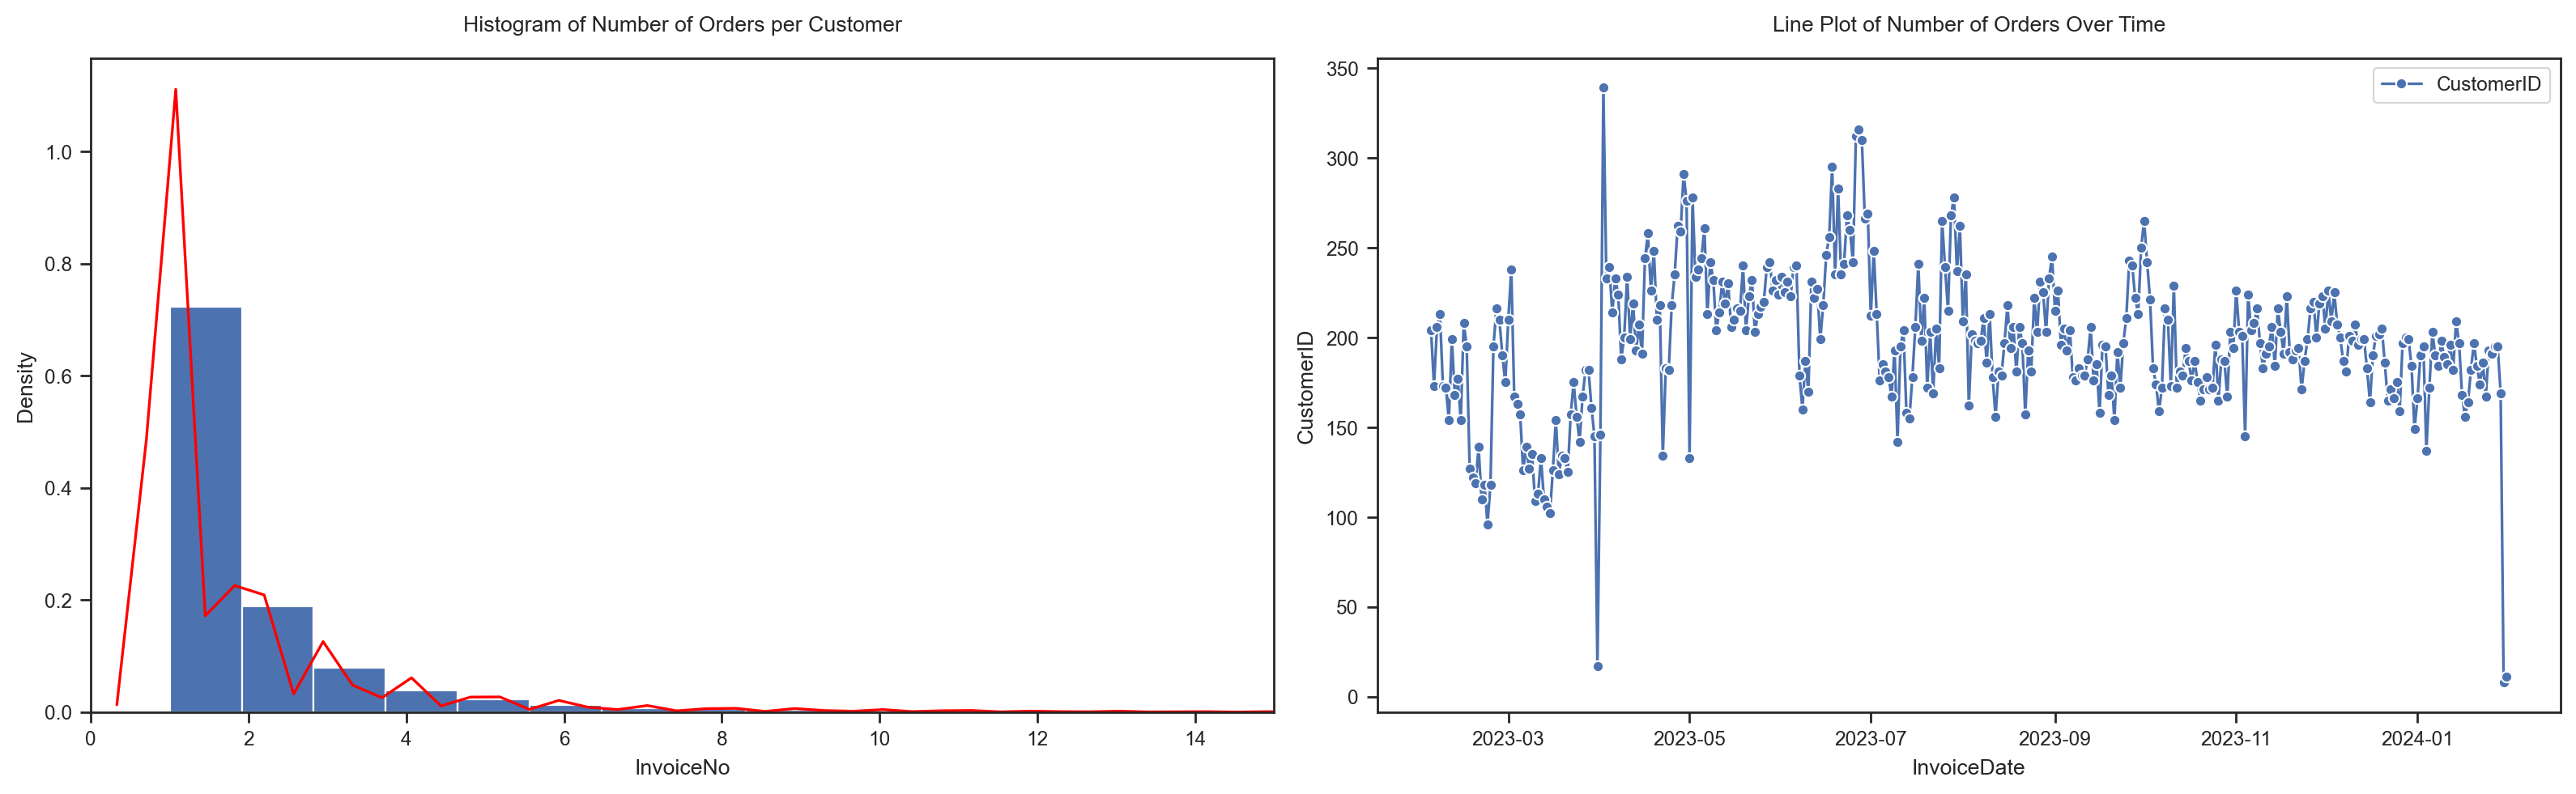

In [21]:
# Plotting histogram of number of orders per customers
plt.figure(figsize=(16, 5))

# Subplot 1: Histogram
plt.subplot(1, 2, 1)
ax1 = sns.distplot(number_orders, bins=80, kde=True, hist=True, hist_kws={'alpha':1})
ax1.lines[0].set_color('red')
plt.xlim(0, 15)
plt.title('Histogram of Number of Orders per Customer')

# Subplot 2: Line plot
plt.subplot(1, 2, 2)
df_month = df.groupby('InvoiceDate').agg({'CustomerID': 'count'}).reset_index()
ax2 = sns.lineplot(x='InvoiceDate', y='CustomerID', data=df_month, label='CustomerID', marker='o')
plt.title('Line Plot of Number of Orders Over Time')

# Adjust layout
plt.tight_layout()
plt.show()

Dari grafik diatas dapat dilihat jika distribusi transaksi customer cenderung berada pada frekuensi yang rendah yaitu 1 kali transaksi, selain itu dapat dilihat juga jika jumlah customer pernah mengalami penurunan dan kenaikan yang tajam pada bulan 4 tahun 2023.

In [22]:
# finding the average customer activity
print('Average number of customers per day: ', df_month['CustomerID'].mean())

Average number of customers per day:  196.0495867768595


In [23]:
# top 15 customers by their total purchases
df_purchases = df.groupby('CustomerID')['InvoiceDate'].count().to_frame().reset_index()
df_purchases.rename(columns={'InvoiceDate': 'TotalPurchases'}, inplace=True)
df_purchases.sort_values(by='TotalPurchases', ascending=False, inplace=True)
df_top_customers = df_purchases.reset_index(drop=True).head(15)

# top 15 customers by their quantity of items purchased
df_quantity = df.groupby('CustomerID')['Quantity'].sum().to_frame().reset_index()
df_quantity.rename(columns={'Quantity': 'TotalQuantity'}, inplace=True)
df_quantity.sort_values(by='TotalQuantity', ascending=False, inplace=True)
df_quantity = df_quantity.reset_index(drop=True).head(15)

# top 15 customers by sales
df['Sales'] = df['Quantity'] * df['UnitPrice']
df_sales = df.groupby('CustomerID')['Sales'].sum().to_frame().reset_index()
df_sales.rename(columns={'Sales': 'TotalSales'}, inplace=True)
df_sales.sort_values(by='TotalSales', ascending=False, inplace=True)
df_sales = df_sales.reset_index(drop=True).head(15)

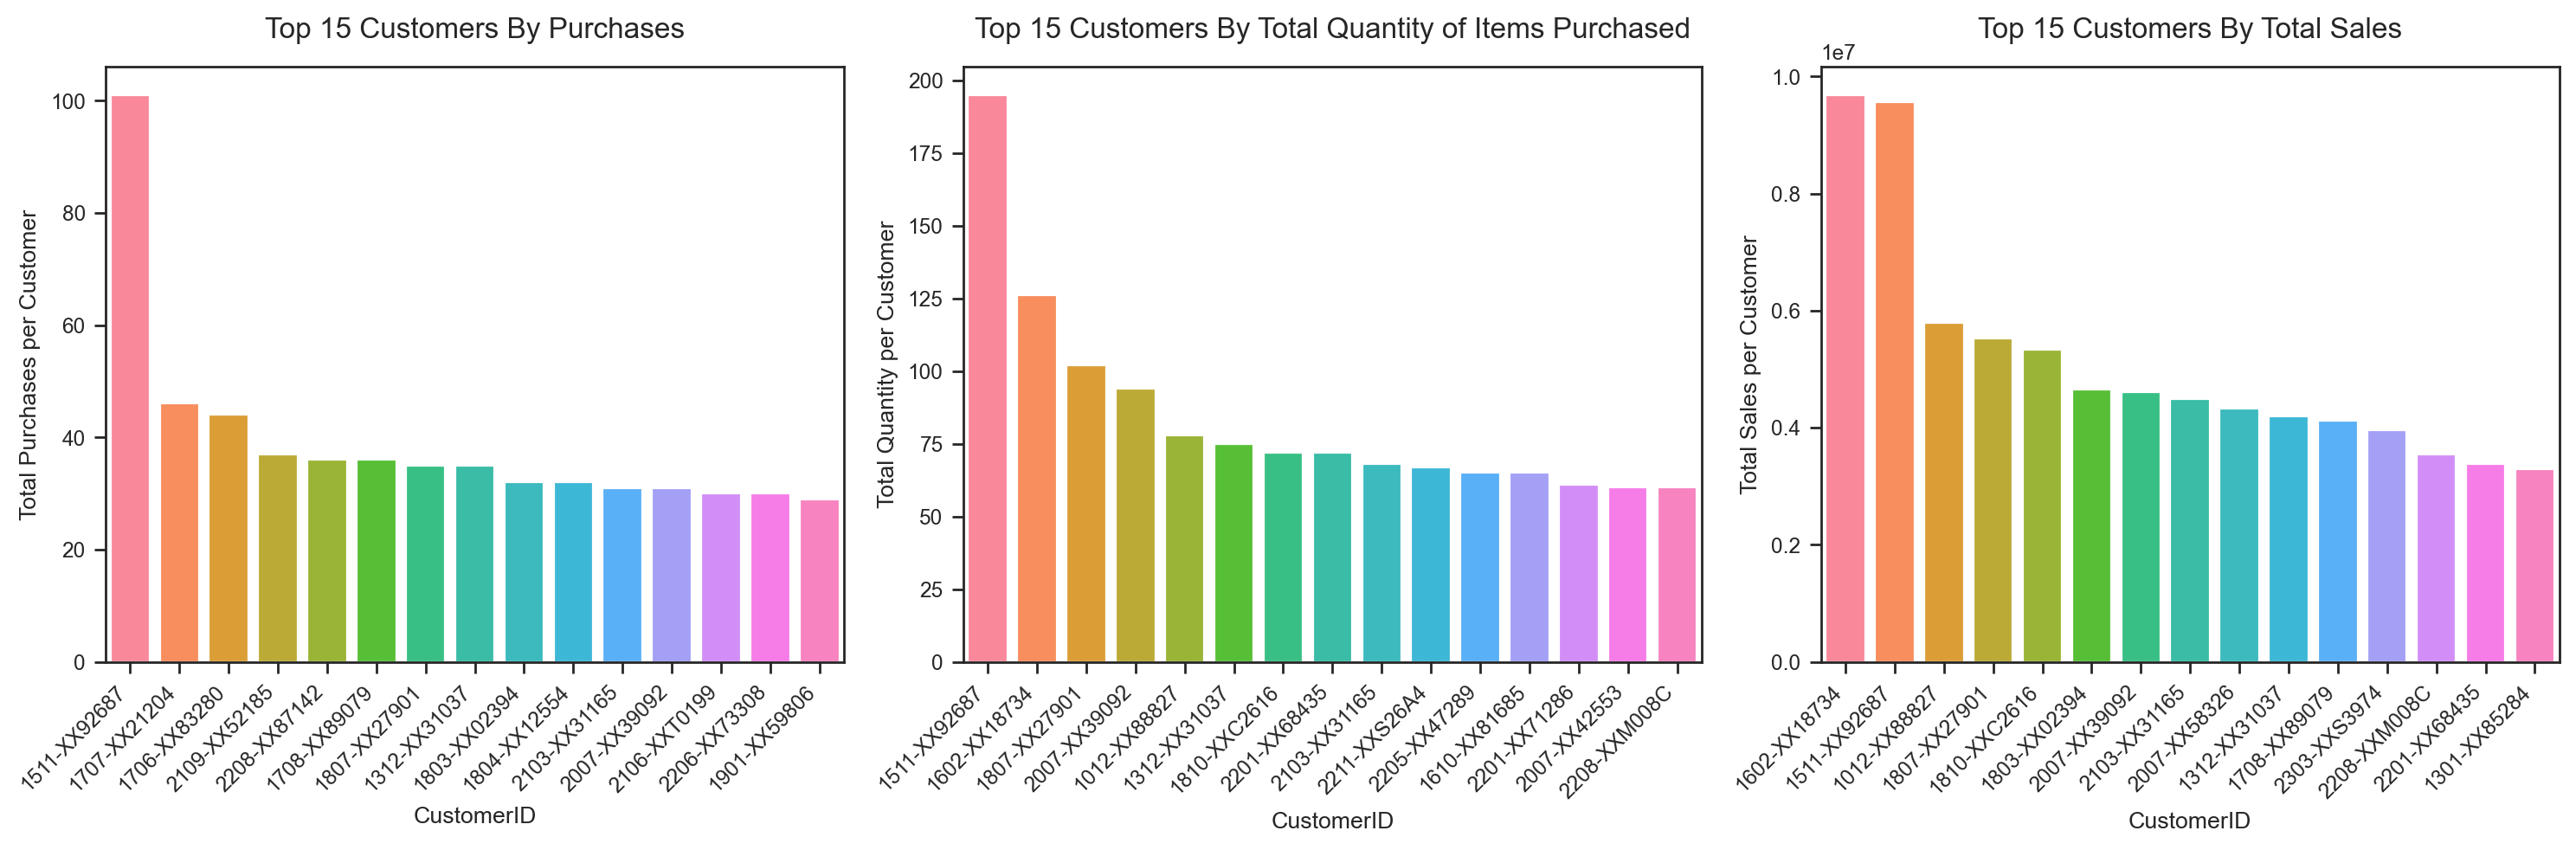

In [24]:
# Plotting top 15 customers by their total purchases, quantity of items purchased, and total sales
plt.figure(figsize=(15, 5))

# Subplot 1: Top 15 customers by total purchases
plt.subplot(1, 3, 1)
sns.barplot(x='CustomerID', y='TotalPurchases', data=df_top_customers,
            order=df_top_customers.sort_values('TotalPurchases', ascending=False)['CustomerID'], saturation=1.0)
plt.ylabel('Total Purchases per Customer')
plt.xlabel('CustomerID')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 15 Customers By Purchases', fontsize=12)

# Subplot 2: Top 15 customers by quantity of items purchased
plt.subplot(1, 3, 2)
sns.barplot(x='CustomerID', y='TotalQuantity', data=df_quantity,
            order=df_quantity.sort_values('TotalQuantity', ascending=False)['CustomerID'], saturation=1.0)
plt.ylabel('Total Quantity per Customer')
plt.xlabel('CustomerID')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 15 Customers By Total Quantity of Items Purchased', fontsize=12)

# Subplot 3: Top 15 customers by total sales
plt.subplot(1, 3, 3)
sns.barplot(x='CustomerID', y='TotalSales', data=df_sales,
            order=df_sales.sort_values('TotalSales', ascending=False)['CustomerID'], saturation=1.0)
plt.ylabel('Total Sales per Customer')
plt.xlabel('CustomerID')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 15 Customers By Total Sales', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

Selanjutnya, kita akan mengevaluasi customer dengan nilai frequency, quantity, dan monetary tertinggi. Ternyata, terdapat satu customer yang merupakan outlier. Hal ini perlu mendapatkan perhatian khusus saat melakukan analisis, karena customer tersebut mungkin memiliki pola transaksi yang sangat berbeda dibandingkan dengan mayoritas customer lainnya.

## Cohort Analysis

Cohort analysis adalah metode analisis yang digunakan dalam bidang bisnis dan pemasaran untuk memahami dan mengevaluasi perilaku customer berdasarkan kelompok atau "cohort" tertentu. Cohort analysis sangat berguna untuk melihat bagaimana perilaku customer berubah seiring waktu, terutama setelah mereka pertama kali terlibat atau melakukan transaksi.

### Customer Retention Rate Cohort Analysis

In [26]:
# get dates in which the customers made the purchases and convert into year and month only
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')
# get a date which each customer made the first purchase and convert into year and month only
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.head(3)

CustomerID NomorHandphone                        InvoiceNo  Quantity  \
0  1909-XX98638   0877XXXXXXXX  KD43-369-301294U42401011XXXXXXX       1.0   
1  1509-XX57585   0857XXXXXXXX  Q271-400-21035MU62304021XXXXXXX       1.0   
2  1602-XX00010   0812XXXXXXXX  P635-129-2003KMKZ2304011XXXXXXX       1.0   

  InvoiceDate  UnitPrice    Sales OrderMonth CohortMonth  
0  2023-12-30    46300.0  46300.0    2023-12     2023-12  
1  2023-03-21    83900.0  83900.0    2023-03     2023-03  
2  2023-03-20    46200.0  46200.0    2023-03     2023-03

In [27]:
# defining function to calculate cohort index
def compute_cohort_index(df, col1, col2):
    order_year = (df[col1].astype(str).str[:4]).astype('int')
    order_month = (df[col1].astype(str).str[5:]).astype('int')
    cohort_year = (df[col2].astype(str).str[:4]).astype('int')
    cohort_month = (df[col2].astype(str).str[5:]).astype('int')
    #return ((order_year - cohort_year) * 12) + order_month - cohort_month
    return (order_year - cohort_year) * 12 + order_month - cohort_month + 1  # multiplying by 12 to convert year difference into months
# adds 1 to the result in order to start the cohort index at 1 rather than 0 (i.e a transaction made in the same month as the acquisition)

In [28]:
# calculate cohort index
df['CohortIndex'] = compute_cohort_index(df, "OrderMonth", "CohortMonth")
df.head(3)

CustomerID NomorHandphone                        InvoiceNo  Quantity  \
0  1909-XX98638   0877XXXXXXXX  KD43-369-301294U42401011XXXXXXX       1.0   
1  1509-XX57585   0857XXXXXXXX  Q271-400-21035MU62304021XXXXXXX       1.0   
2  1602-XX00010   0812XXXXXXXX  P635-129-2003KMKZ2304011XXXXXXX       1.0   

  InvoiceDate  UnitPrice    Sales OrderMonth CohortMonth  CohortIndex  
0  2023-12-30    46300.0  46300.0    2023-12     2023-12            1  
1  2023-03-21    83900.0  83900.0    2023-03     2023-03            1  
2  2023-03-20    46200.0  46200.0    2023-03     2023-03            1

In [29]:
# finding unique number of customers for each cohort month and cohort index
cohort_counts = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique()
df_cohort_counts = cohort_counts.to_frame().rename(columns={'CustomerID':'CustomerCounts'}).sort_values(by=['CohortMonth', 'CohortIndex'])

# find maximum number of customer counts for each month
df_cohort_counts.groupby(["CohortMonth"])["CustomerCounts"].transform("max").to_frame()

# compute the retention rate for each month by dividing the total number of customers in each index with the highest number of customers in all indexes in that month
df_cohort_counts['RetentionRate'] = (df_cohort_counts['CustomerCounts'] / df_cohort_counts.groupby(["CohortMonth"])["CustomerCounts"].transform("max")).round(2)
df_cohort_counts.sort_values(by=['CohortMonth', 'CohortIndex'])

CustomerCounts  RetentionRate
CohortMonth CohortIndex                               
2023-02     1                      3340           1.00
            2                       782           0.23
            3                       510           0.15
            4                       463           0.14
            5                       396           0.12
...                                 ...            ...
2023-11     2                       437           0.15
            3                       271           0.09
2023-12     1                      2782           1.00
            2                       438           0.16
2024-01     1                      2381           1.00

[78 rows x 2 columns]

In [30]:
# produce the pivot table of the customer counts for each month and cohort index
cohort_pivot = df_cohort_counts.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerCounts')

# reproduce the pivot table to show the rate of monthly recurring customer (retention rates)
cohort_pivot_retention = df_cohort_counts.pivot_table(index='CohortMonth', columns='CohortIndex', values='RetentionRate').round(2)

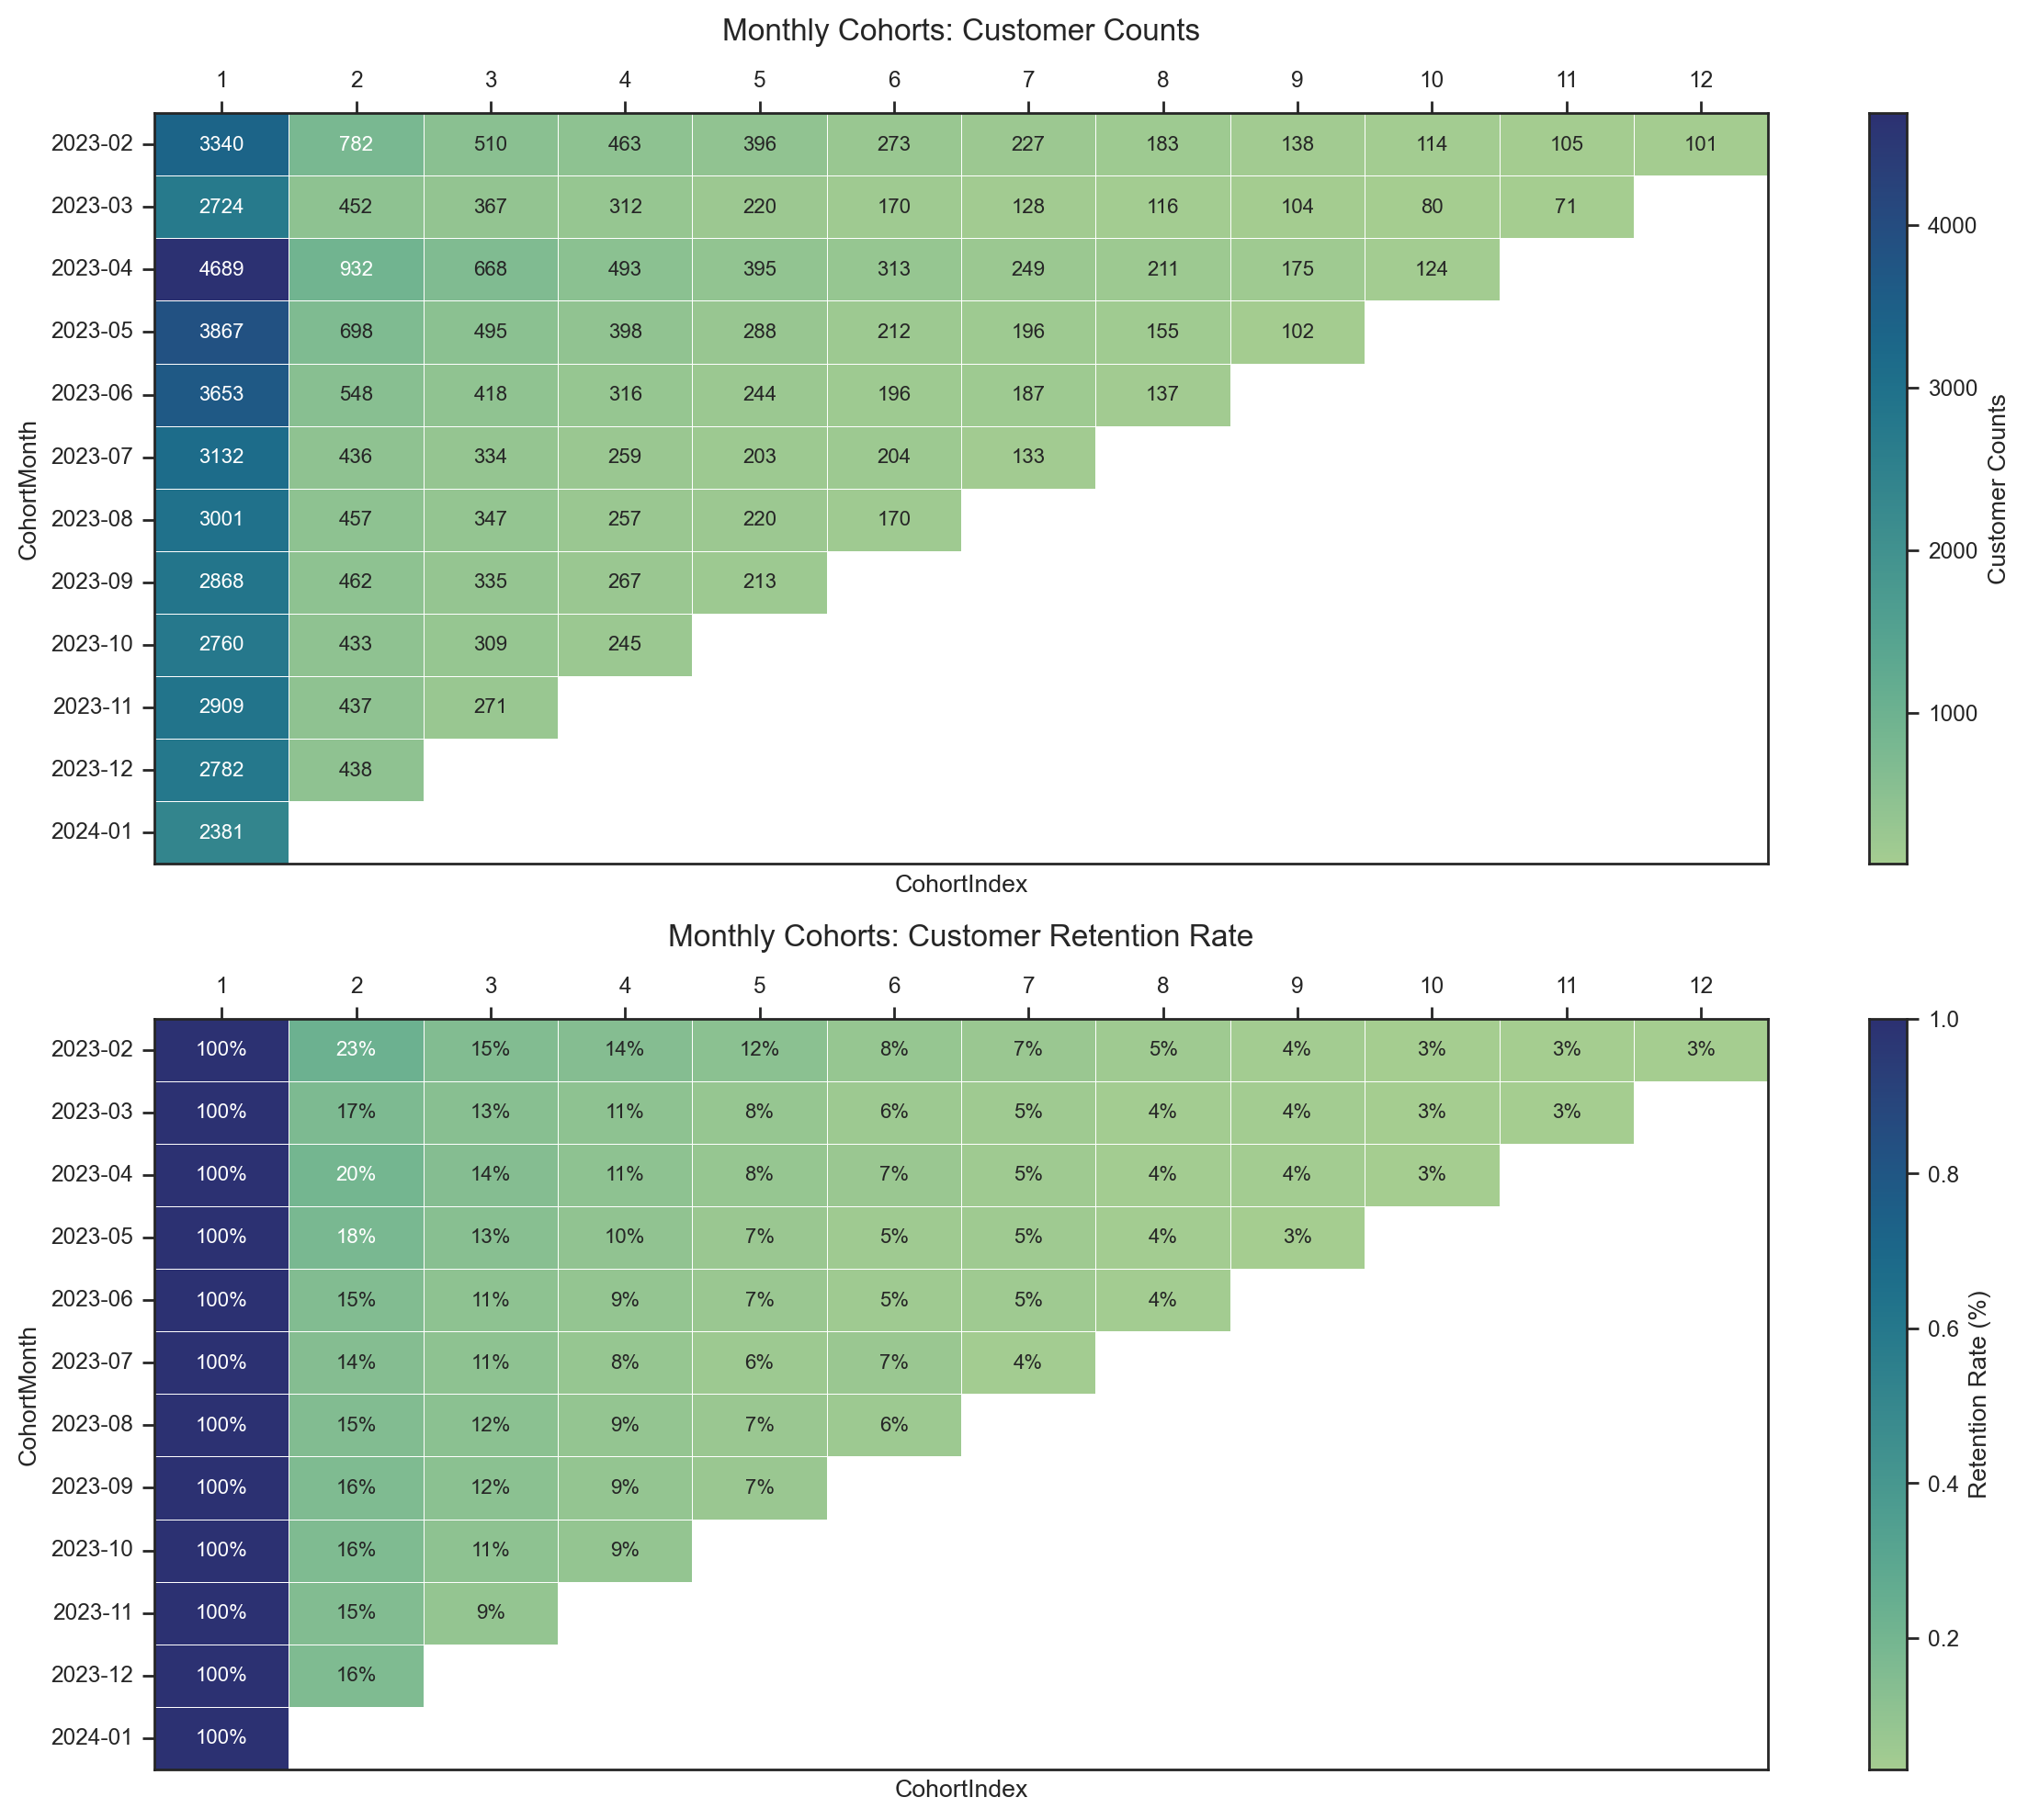

In [31]:
# Plotting the retention rate pivot table as heatmaps
plt.figure(figsize=(12, 10))

# Subplot 1: Monthly Cohorts - Customer Counts
plt.subplot(2, 1, 1)
plt.title("Monthly Cohorts: Customer Counts", fontsize=12)
ax1 = sns.heatmap(data=cohort_pivot, annot=True, fmt='.0f', cmap="crest", linewidth=.3,
                  annot_kws={'size': '8'}, cbar_kws={'label': 'Customer Counts'})
ax1.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

# Subplot 2: Monthly Cohorts - Customer Retention Rate
plt.subplot(2, 1, 2)
plt.title("Monthly Cohorts: Customer Retention Rate", fontsize=12)
ax2 = sns.heatmap(data=cohort_pivot_retention, annot=True, fmt='.0%', cmap="crest", linewidth=.3,
                  annot_kws={'size': '8'}, cbar_kws={'label': 'Retention Rate (%)'})
ax2.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Dari grafik di atas, terlihat bahwa sekitar 90% customer berpotensi churn pada bulan ke-3 dan ke-4. Hal ini dapat menjadi salah satu fokus tim marketing untuk memantau customer yang sudah melakukan transaksi sebelum mencapai 3 bulan agar dapat mencegah mereka menjadi churn customer.

### Quantity & Revenue Cohort Analysis

In [32]:
# finding total quantity for each cohort month and cohort index
cohort_quantity = df.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].apply(pd.Series.sum).round(2)
df_cohort_quantity = cohort_quantity.to_frame().rename(columns={'Quantity':'TotalQuantity'}).sort_values(by=['CohortMonth', 'CohortIndex'])

# produce the pivot table of total quantity for each month and cohort index
cohort_pivot_quantity = df_cohort_quantity.pivot_table(index='CohortMonth', columns='CohortIndex', values='TotalQuantity')


# finding total sales for each cohort month and cohort index
cohort_sales = df.groupby(['CohortMonth', 'CohortIndex'])['Sales'].apply(pd.Series.sum).round(2)
df_cohort_sales = cohort_sales.to_frame().rename(columns={'Sales':'TotalSales'}).sort_values(by=['CohortMonth', 'CohortIndex'])

# produce the pivot table of total sales for each month and cohort index
cohort_pivot_sales = df_cohort_sales.pivot_table(index='CohortMonth', columns='CohortIndex', values='TotalSales')

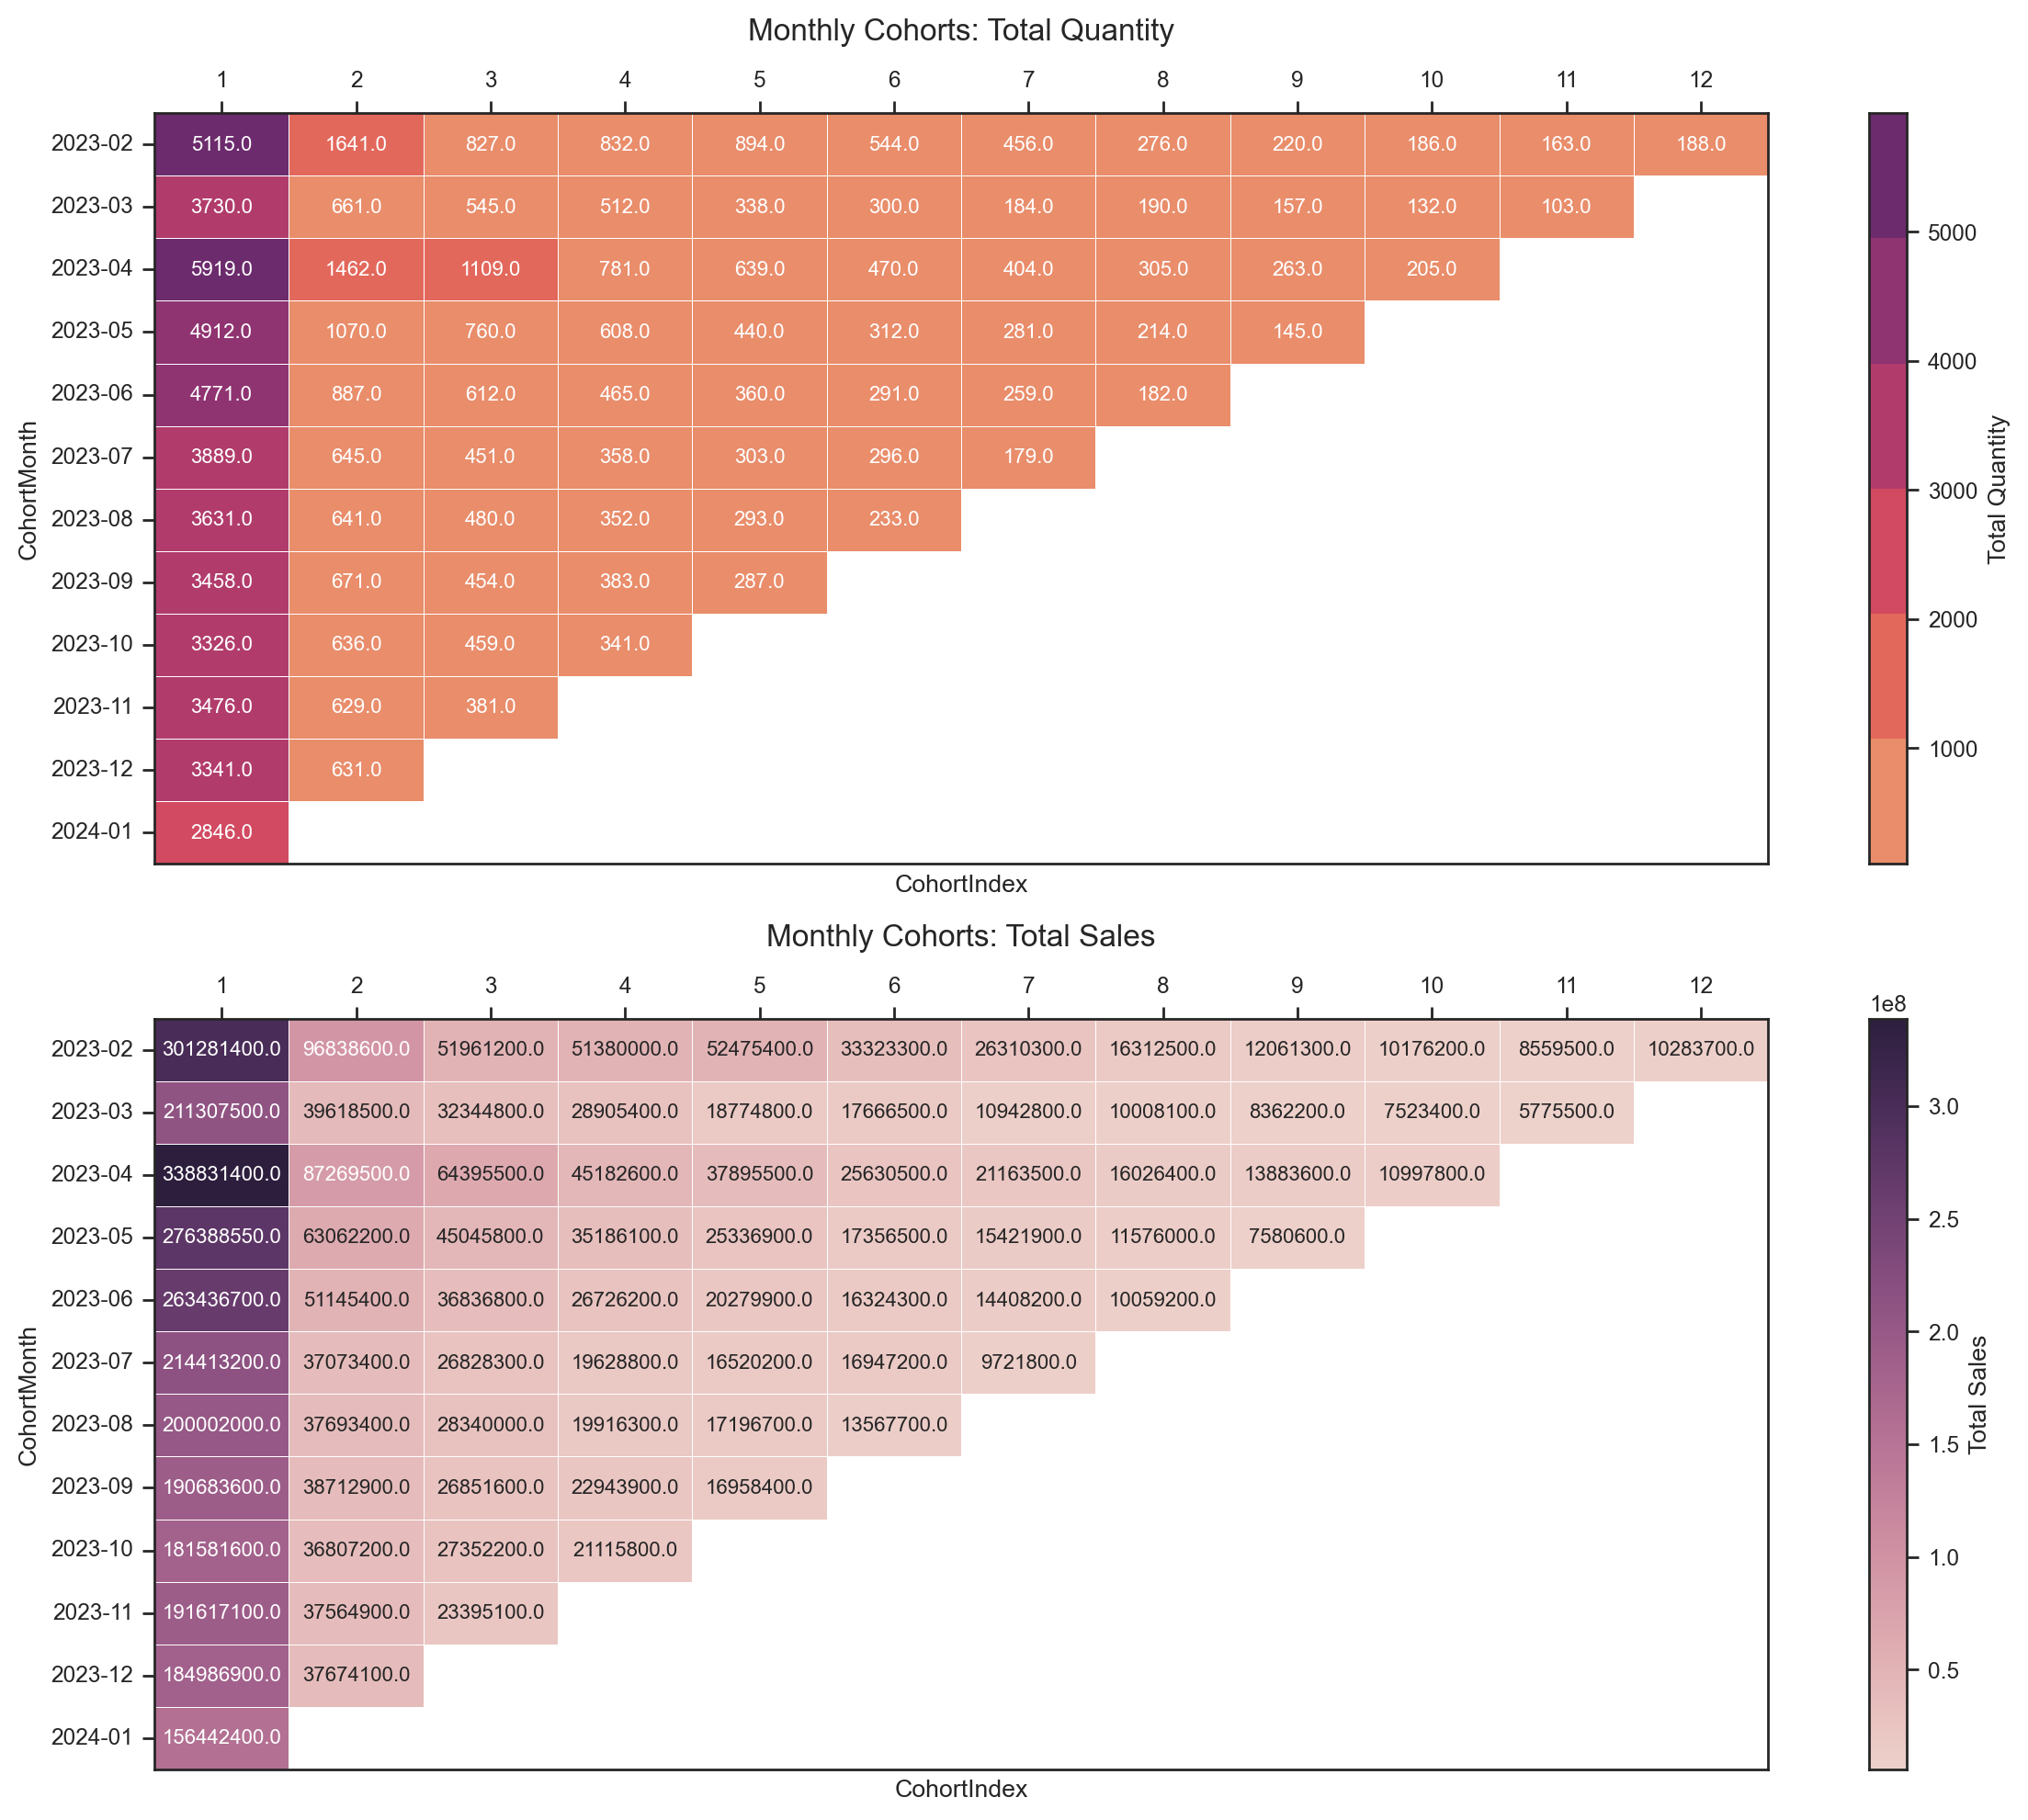

In [33]:
# Plotting heatmaps of the pivot tables
plt.figure(figsize=(12, 10))

# Subplot 1: Monthly Cohorts - Total Quantity
plt.subplot(2, 1, 1)
plt.title("Monthly Cohorts: Total Quantity", fontsize=12)
ax1 = sns.heatmap(data=cohort_pivot_quantity, annot=True, fmt='0', cmap=sns.color_palette("flare"), linewidth=.3,
                  annot_kws={'size': '8'}, cbar_kws={'label': 'Total Quantity'})
ax1.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

# Subplot 2: Monthly Cohorts - Total Sales
plt.subplot(2, 1, 2)
plt.title("Monthly Cohorts: Total Sales", fontsize=12)
ax2 = sns.heatmap(data=cohort_pivot_sales, annot=True, fmt='2', cmap=sns.cubehelix_palette(as_cmap=True), linewidth=.3,
                  annot_kws={'size': '8'}, cbar_kws={'label': 'Total Sales'})
ax2.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
# computing total monthly sales for each customer in a cohort index
df_cust_monthly_sales = df.groupby(['CohortMonth', 'CohortIndex', 'CustomerID'])['Sales'].sum().to_frame()
df_cust_monthly_sales = df_cust_monthly_sales.rename(columns={'Sales': 'TotalMonthlySales'}).sort_values(by=['CohortMonth', 'CohortIndex','TotalMonthlySales'], ascending=False)

# we find top 10 customers for each month in terms of total monthly sales
idx = df_cust_monthly_sales.groupby(['CohortMonth', 'CohortIndex'])['TotalMonthlySales'].transform(max) == df_cust_monthly_sales['TotalMonthlySales']
df_top_monthly_cust = df_cust_monthly_sales[idx].sort_values(by=['TotalMonthlySales'], ascending=False)
df_top_monthly_cust.head(10)

TotalMonthlySales
CohortMonth CohortIndex CustomerID                     
2023-07     1           1810-XXC2616          5328000.0
2023-02     2           2007-XX58326          3581900.0
2023-03     1           2208-XXM008C          3540000.0
2023-06     1           1801-XX60420          2972900.0
2023-02     5           1511-XX92687          2887500.0
2023-06     2           1606-XX60870          2268700.0
2023-02     6           1803-XX02394          2231300.0
2023-04     2           1602-XX18734          2212000.0
2023-02     1           1511-XX92687          2018300.0
2023-12     1           0707-XX92221          1888500.0

## Versi 1 : RFM Analysis

In [35]:
# picking a random date (after the date of the last sale) for the RFM analysis
today_date = date.today().strftime("%Y-%m-%d")
today_date

'2024-02-02'

In [36]:
today_date = dt.datetime(2024, 1, 22).strftime("%Y-%m-%d")
today_date

'2024-01-22'

In [37]:
# changing OrderMonth to include the original days
df['OrderMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m-%d')
df.head(3)

CustomerID NomorHandphone                        InvoiceNo  Quantity  \
0  1909-XX98638   0877XXXXXXXX  KD43-369-301294U42401011XXXXXXX       1.0   
1  1509-XX57585   0857XXXXXXXX  Q271-400-21035MU62304021XXXXXXX       1.0   
2  1602-XX00010   0812XXXXXXXX  P635-129-2003KMKZ2304011XXXXXXX       1.0   

  InvoiceDate  UnitPrice    Sales  OrderMonth CohortMonth  CohortIndex  
0  2023-12-30    46300.0  46300.0  2023-12-30     2023-12            1  
1  2023-03-21    83900.0  83900.0  2023-03-21     2023-03            1  
2  2023-03-20    46200.0  46200.0  2023-03-20     2023-03            1

In [38]:
import pandas as pd
from datetime import datetime

# Assuming 'today_date' is defined somewhere in your code
today_date = datetime.now()

# Convert 'OrderMonth' to datetime
df['OrderMonth'] = pd.to_datetime(df['OrderMonth'])

# Calculate RFM metrics
df_rfm = df.groupby('CustomerID').agg({
    'OrderMonth': lambda x: (today_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Sales': 'sum'
}).rename(columns={
    'OrderMonth': 'Recency',
    'InvoiceNo': 'Frequency',
    'Sales': 'Monetary'
}).reset_index()

# Print or use df_rfm as needed
print(df_rfm.head())

     CustomerID  Recency  Frequency  Monetary
0  0611-XX51632      132          3  186500.0
1  0701-XX56807      107          5  274500.0
2  0702-XX50535      191          1   85800.0
3  0705-XX13241      183          1   85800.0
4  0705-XX13823      117          1   47800.0


In [39]:
df_rfm.describe()

Recency    Frequency      Monetary
count  38106.000000  38106.00000  3.810600e+04
mean     167.310791      1.80444  1.184112e+05
std      103.384991      1.84550  1.883425e+05
min        2.000000      1.00000  8.400000e+03
25%       74.000000      1.00000  4.630000e+04
50%      164.000000      1.00000  8.330000e+04
75%      255.000000      2.00000  1.314750e+05
max      364.000000     74.00000  9.683000e+06

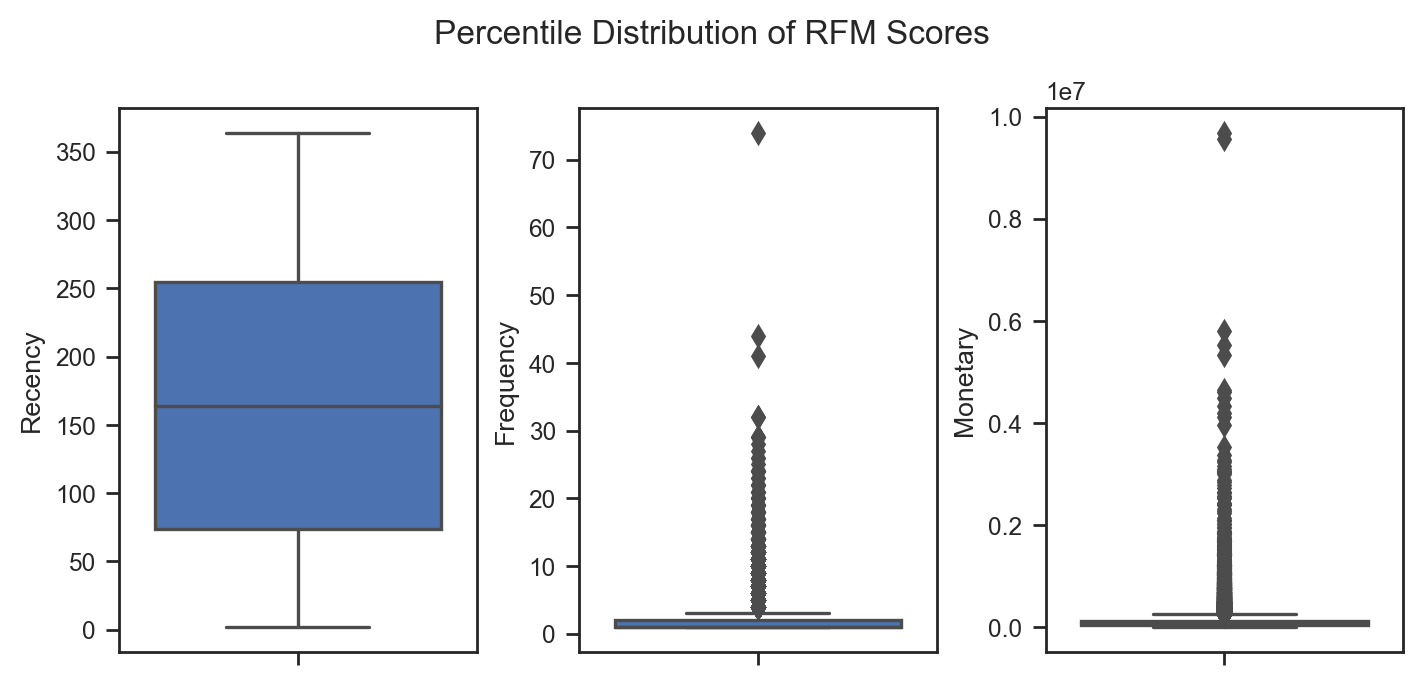

In [40]:
# plotting percentile distribution of RFM scores
cols = ['Recency', 'Frequency', 'Monetary']
fig,axes = plt.subplots(1, len(cols), figsize=(7,3), constrained_layout=True, sharex=False)
axes = axes.flatten()
for col in cols :
    sns.boxplot(y=df_rfm[col], ax=axes[cols.index(col)], saturation=1.0)
plt.suptitle("Percentile Distribution of RFM Scores", fontsize=12, y=1.09)
plt.show()

Dari boxplot di atas, terlihat bahwa terdapat banyak outlier pada variabel frequency dan monetary. Outlier ini menyebabkan data tidak dapat langsung dianalisis, melainkan perlu dikelompokkan berdasarkan nilai persentil atau distandardisasi terlebih dahulu.

In [41]:
# finding top customers by monetary and frequency values
df_rfm.sort_values(by=['Monetary', 'Frequency'], ascending=[False, False], inplace=True)
df_rfm.head(3)

CustomerID  Recency  Frequency   Monetary
4965  1602-XX18734       36         14  9683000.0
4600  1511-XX92687       10         74  9560100.0
583   1012-XX88827      153         21  5793500.0

In [42]:
# binning rfm scores into 3 quantiles
df_quartiles = df_rfm[['Recency','Frequency','Monetary']].quantile(q=[0.25,0.50,0.75])
df_quartiles

Recency  Frequency  Monetary
0.25     74.0        1.0   46300.0
0.50    164.0        1.0   83300.0
0.75    255.0        2.0  131475.0

In [43]:
# creating a binning function for each metric, 1 being the lowest and 4 the highest
def recency_score(x):
    if x <= df_quartiles.loc[0.25,'Recency']:
        return 1
    elif (x > df_quartiles.loc[0.25,'Recency']) and (x <= df_quartiles.loc[0.50,'Recency']):
        return 2
    elif (x > df_quartiles.loc[0.50,'Recency']) and (x <= df_quartiles.loc[0.75,'Recency']):
        return 3
    else:
        return 4

def frequency_score(x):
    if x <= df_quartiles.loc[0.25,'Frequency']:
        return 1
    elif (x > df_quartiles.loc[0.25,'Frequency']) and (x <= df_quartiles.loc[0.50,'Frequency']):
        return 2
    elif (x > df_quartiles.loc[0.50,'Frequency']) and (x <= df_quartiles.loc[0.75,'Frequency']):
        return 3
    else:
        return 4

def monetary_score(x):
    if x <= df_quartiles.loc[0.25,'Monetary']:
        return 1
    elif (x > df_quartiles.loc[0.25,'Monetary']) and (x <= df_quartiles.loc[0.50,'Monetary']):
        return 2
    elif (x > df_quartiles.loc[0.50,'Monetary']) and (x <= df_quartiles.loc[0.75,'Monetary']):
        return 3
    else:
        return 4

In [44]:
# Calculating RFM scores
df_rfm['Recency_Score'] = df_rfm['Recency'].apply(recency_score)
df_rfm['Frequency_Score'] = df_rfm['Frequency'].apply(frequency_score)
df_rfm['Monetary_Score'] = df_rfm['Monetary'].apply(monetary_score)
df_rfm.head()

CustomerID  Recency  Frequency   Monetary  Recency_Score  \
4965   1602-XX18734       36         14  9683000.0              1   
4600   1511-XX92687       10         74  9560100.0              1   
583    1012-XX88827      153         21  5793500.0              2   
10847  1807-XX27901      168         24  5525300.0              3   
11962  1810-XXC2616      203          1  5328000.0              3   

       Frequency_Score  Monetary_Score  
4965                 4               4  
4600                 4               4  
583                  4               4  
10847                4               4  
11962                1               4

In [45]:
df_rfm['Recency_Score'].value_counts()

Recency_Score
3    9591
1    9582
2    9495
4    9438
Name: count, dtype: int64

In [46]:
df_rfm['RFM_Segment'] = df_rfm['Recency_Score'].astype(str) + df_rfm['Frequency_Score'].astype(str) + df_rfm['Monetary_Score'].astype(str)
df_rfm['RFM_Score'] = df_rfm['Recency_Score'].astype(int) + df_rfm['Frequency_Score'].astype(int) + df_rfm['Monetary_Score'].astype(int)
df_rfm.sort_values(by='RFM_Segment', ascending=False).head(5)

CustomerID  Recency  Frequency  Monetary  Recency_Score  \
10598  1806-XX04639      264          3  178400.0              4   
61     0711-XX99676      259          3  258100.0              4   
35703  2302-XX60611      257          3  257900.0              4   
1686   1305-XX04436      263          3  140200.0              4   
13947  1906-XX87412      322          3  140200.0              4   

       Frequency_Score  Monetary_Score RFM_Segment  RFM_Score  
10598                4               4         444         12  
61                   4               4         444         12  
35703                4               4         444         12  
1686                 4               4         444         12  
13947                4               4         444         12

In [47]:
# identifying max and min values of RFM_Segment and RFM_Score
df_rfm.agg({ 'RFM_Segment': ['min', 'max'], 'RFM_Score': ['min', 'max'] })

RFM_Segment  RFM_Score
min         111          3
max         444         12

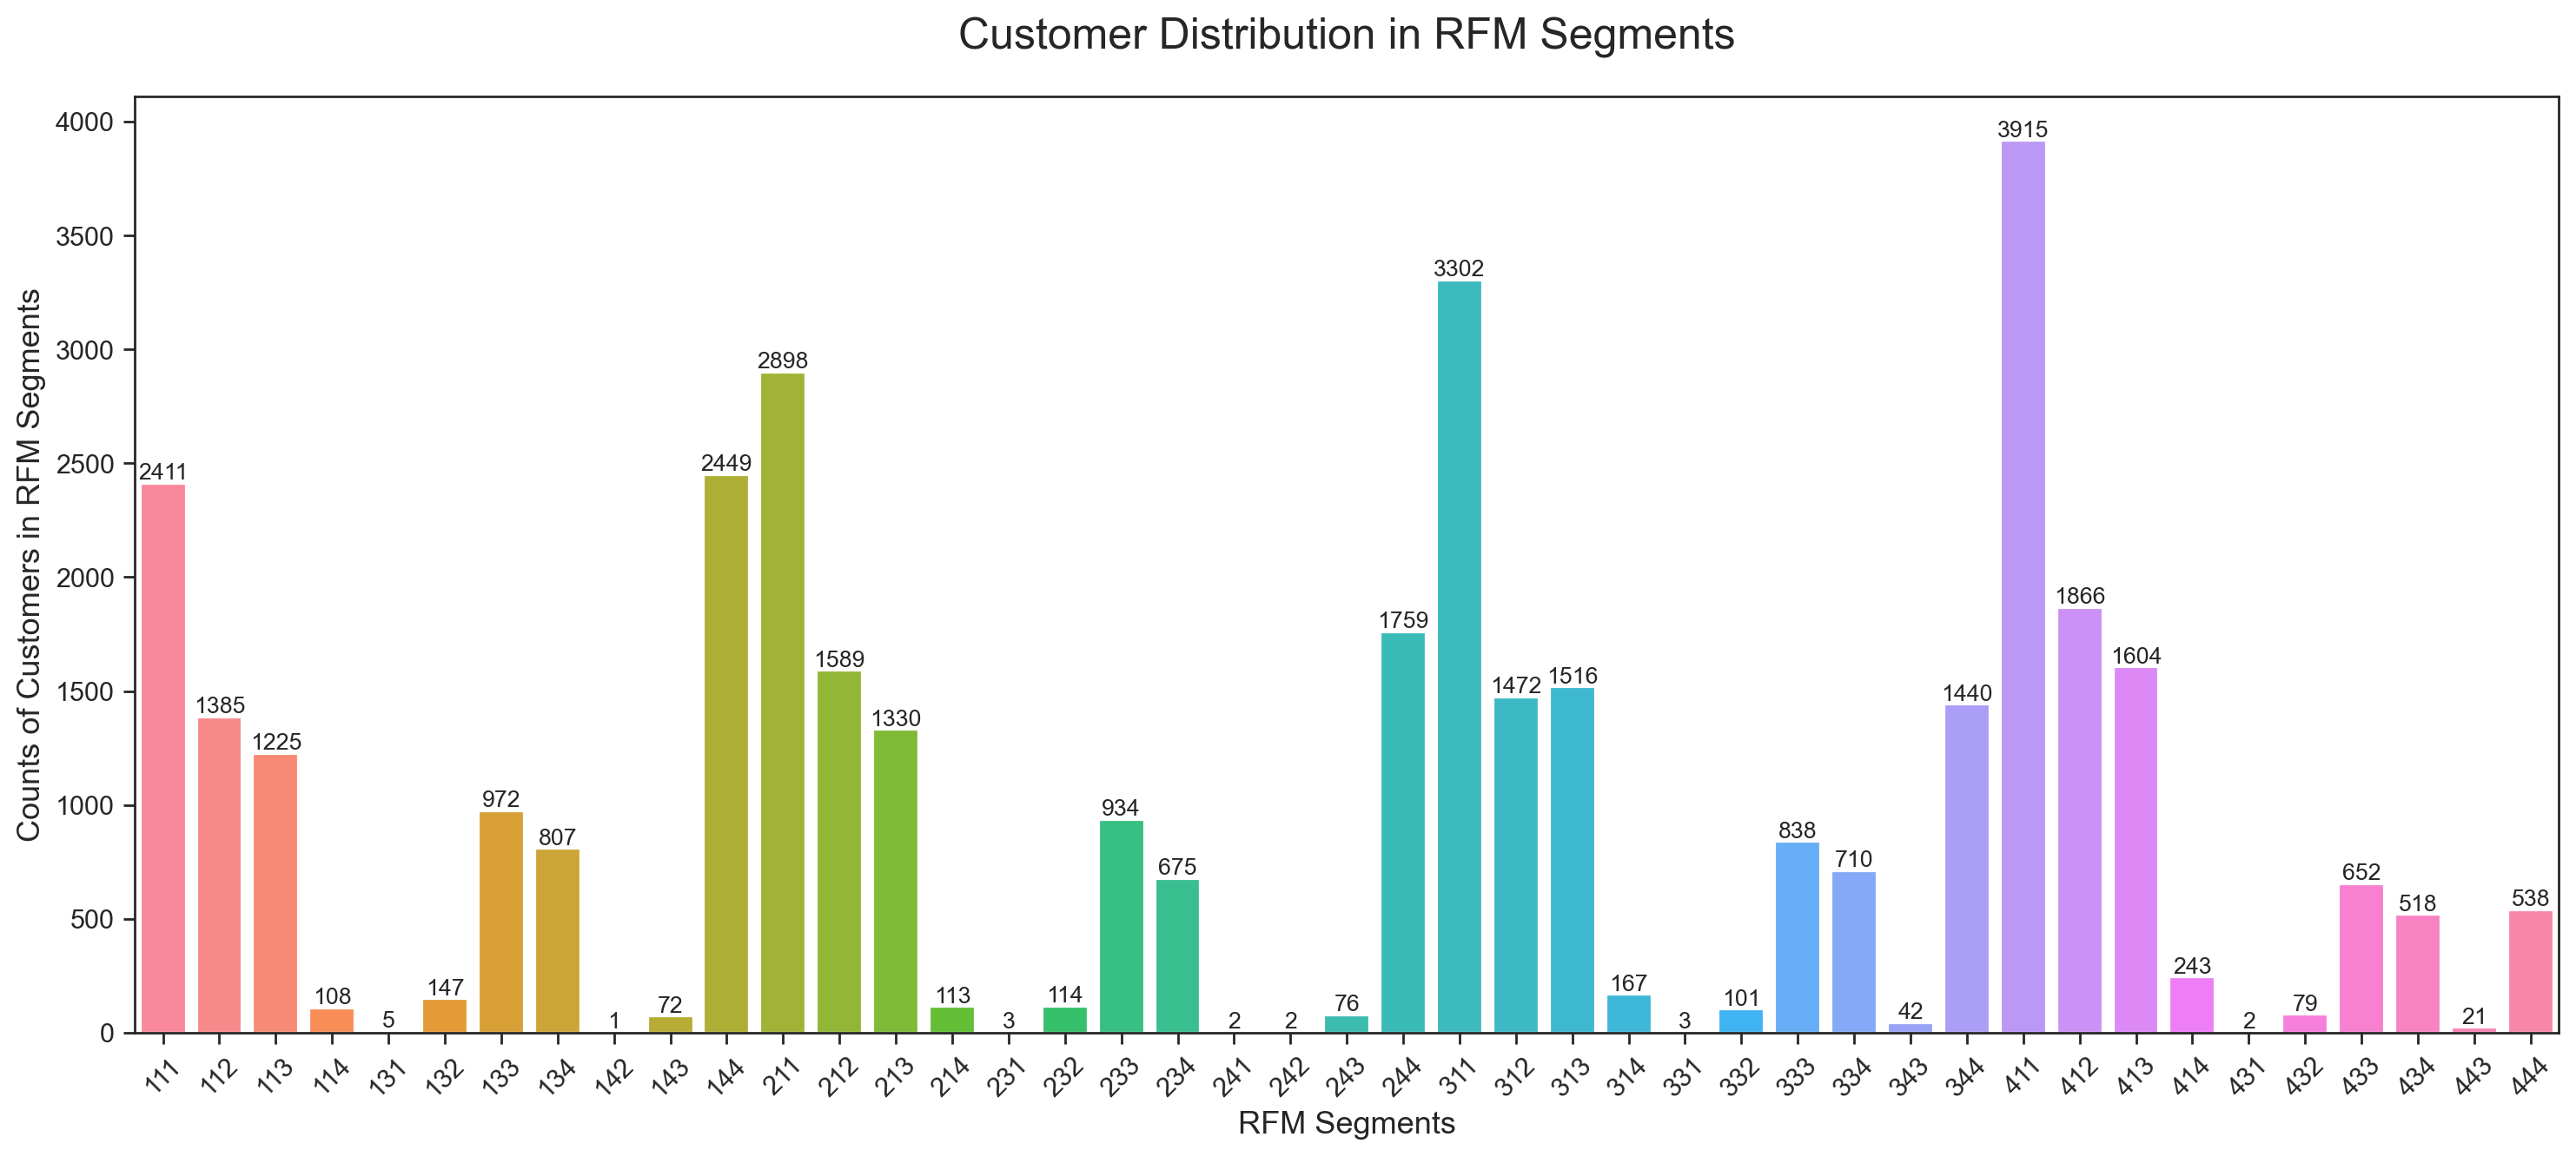

In [48]:
# plot counts of each RFM_Segment
fig, ax = plt.subplots(figsize=(18, 7))
ax = sns.countplot(data=df_rfm.sort_values(by='RFM_Segment'), x='RFM_Segment', saturation=1.0)
ax.bar_label(ax.containers[0])  # display figures on top of bars
plt.title("Customer Distribution in RFM Segments", fontsize=18, y=1.02)
plt.xlabel('RFM Segments', fontsize=13)
plt.ylabel('Counts of Customers in RFM Segments', fontsize=13)
plt.xticks(rotation=45)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.show()
#fig.savefig('D:/Roudhotul Maemanah/Portofolio/RFM/Distribution_of_RFM_Segments.png', format='png', dpi=1200)

Dapat diamati bahwa mayoritas pelanggan Prenagen memiliki nilai recency yang tinggi, sementara nilai frequency dan monetary mereka cenderung rendah. Selanjutnya, segmen ini akan dikelompokkan ke dalam 3 kelas dengan cara menambahkan nilai dari masing-masing segmennya.

In [49]:
# defining a new classification of customers based on their RFM scores
def customer_ranking(a):
    if  (a <= 4):
        return 'Low Tier Customer'
    elif (a > 4) and (a <= 8):
        return 'Mid Tier Customer'
    else:
        return 'High Tier Customer'

In [50]:
# creating a column of customer classifition based on their RFM scores
df_rfm['Customer_Class'] = df_rfm['RFM_Score'].apply(customer_ranking)

# calculating average and median RFM_scores
avg_rfm_score = df_rfm['RFM_Score'].mean()
median_rfm_score = df_rfm['RFM_Score'].median()
# RFM segments summary
print('Average RFM score of all customers: {}\nMedian RFM score of all customers: {}'\
     .format(round(avg_rfm_score, 2), median_rfm_score))

Average RFM score of all customers: 6.76
Median RFM score of all customers: 6.0


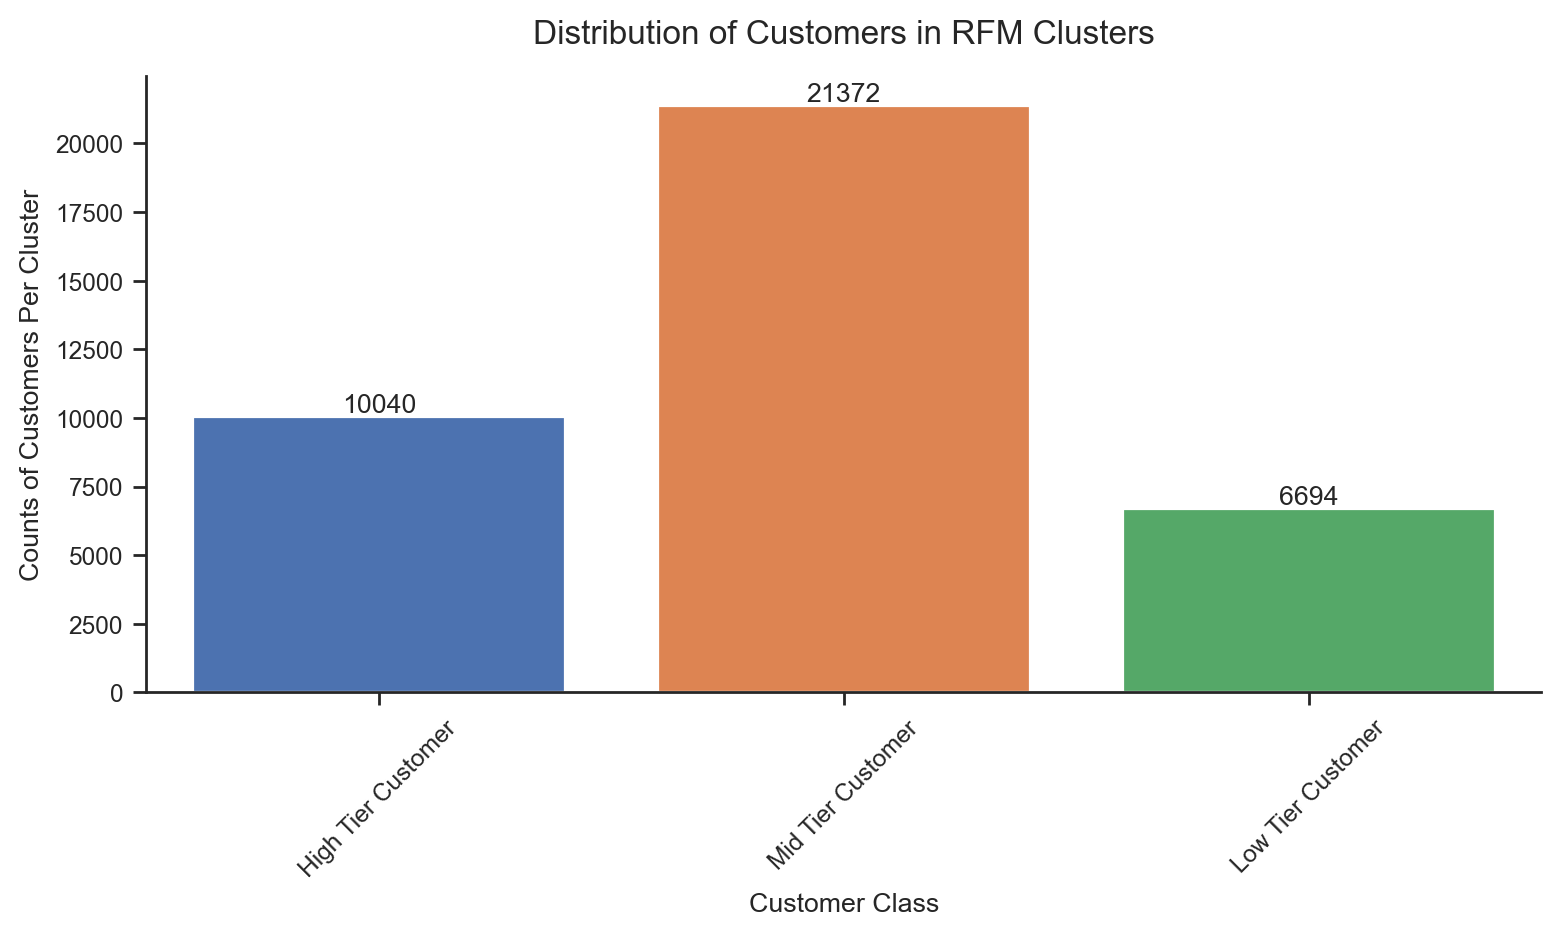

In [51]:
order_class = ['High Tier Customer', 'Mid Tier Customer', 'Low Tier Customer']

# Sorting the dataframe by 'RFM_Score'
df_rfm = df_rfm.sort_values(by='RFM_Score', ascending=True)

# Plotting counts of each customer class
fig, ax = plt.subplots(figsize=(9, 4))
ax = sns.countplot(data=df_rfm, x='Customer_Class', saturation=1.0, order=order_class)
ax.bar_label(ax.containers[0])  # Display figures on top of bars
ax.tick_params(axis='x', labelrotation=45)
sns.despine(fig=None, ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax.set_title('Distribution of Customers in RFM Clusters', fontsize=12)
ax.set_xlabel('Customer Class')
ax.set_ylabel('Counts of Customers Per Cluster')

plt.show()
#fig.savefig('D:/Roudhotul Maemanah/Portofolio/RFM/Distribution_of_Customers_in_RFM_Clusters.png', format='png', dpi=1200)

In [52]:
# Calculate RFM metrics
df_rfm.groupby('Customer_Class').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

Customer_Class     Recency  Frequency       Monetary
0  High Tier Customer  161.759064   3.728685  268505.463147
1   Low Tier Customer   73.371975   1.000000   44828.577831
2   Mid Tier Customer  199.341756   1.152442   70947.959948

Mayoritas customer brand A tergolong sebagai mid-tier customer class, yaitu pelanggan yang memiliki nilai frequency dan monetary yang sedang (cenderung kecil), namun memiliki nilai recency yang tinggi.

In [54]:
df_rfm.groupby('Customer_Class').agg({
    'Recency': 'median',
    'Frequency': 'median',
    'Monetary': 'median'
})

Recency  Frequency  Monetary
Customer_Class                                  
High Tier Customer    166.0        3.0  181600.0
Low Tier Customer      65.0        1.0   46300.0
Mid Tier Customer     214.0        1.0   48200.0

## Versi 2 : Clustering Analysis

In [55]:
# handling nearly zero values because log transformation of these values would result in infinte values
# creating a function to manage zero values
def handle_zero_values(x):
    if x <= 0:
        return 1
    else:
        return x

# applying the function
df_rfm.Recency = df_rfm.Recency.apply(handle_zero_values)
df_rfm.Frequency = df_rfm.Frequency.apply(handle_zero_values)
df_rfm.Monetary = df_rfm.Monetary.apply(handle_zero_values)

In [56]:
df_rfm.head(3)

CustomerID  Recency  Frequency  Monetary  Recency_Score  \
14773  1909-XX98638       34          1   46300.0              1   
22023  2105-XX50098       60          1   37900.0              1   
21873  2105-XX16296       48          1   37900.0              1   

       Frequency_Score  Monetary_Score RFM_Segment  RFM_Score  \
14773                1               1         111          3   
22023                1               1         111          3   
21873                1               1         111          3   

          Customer_Class  
14773  Low Tier Customer  
22023  Low Tier Customer  
21873  Low Tier Customer

In [57]:
# transforming the RFM score into log form
df_rfm_log = df_rfm[cols].apply(np.log, axis=0).round(2)

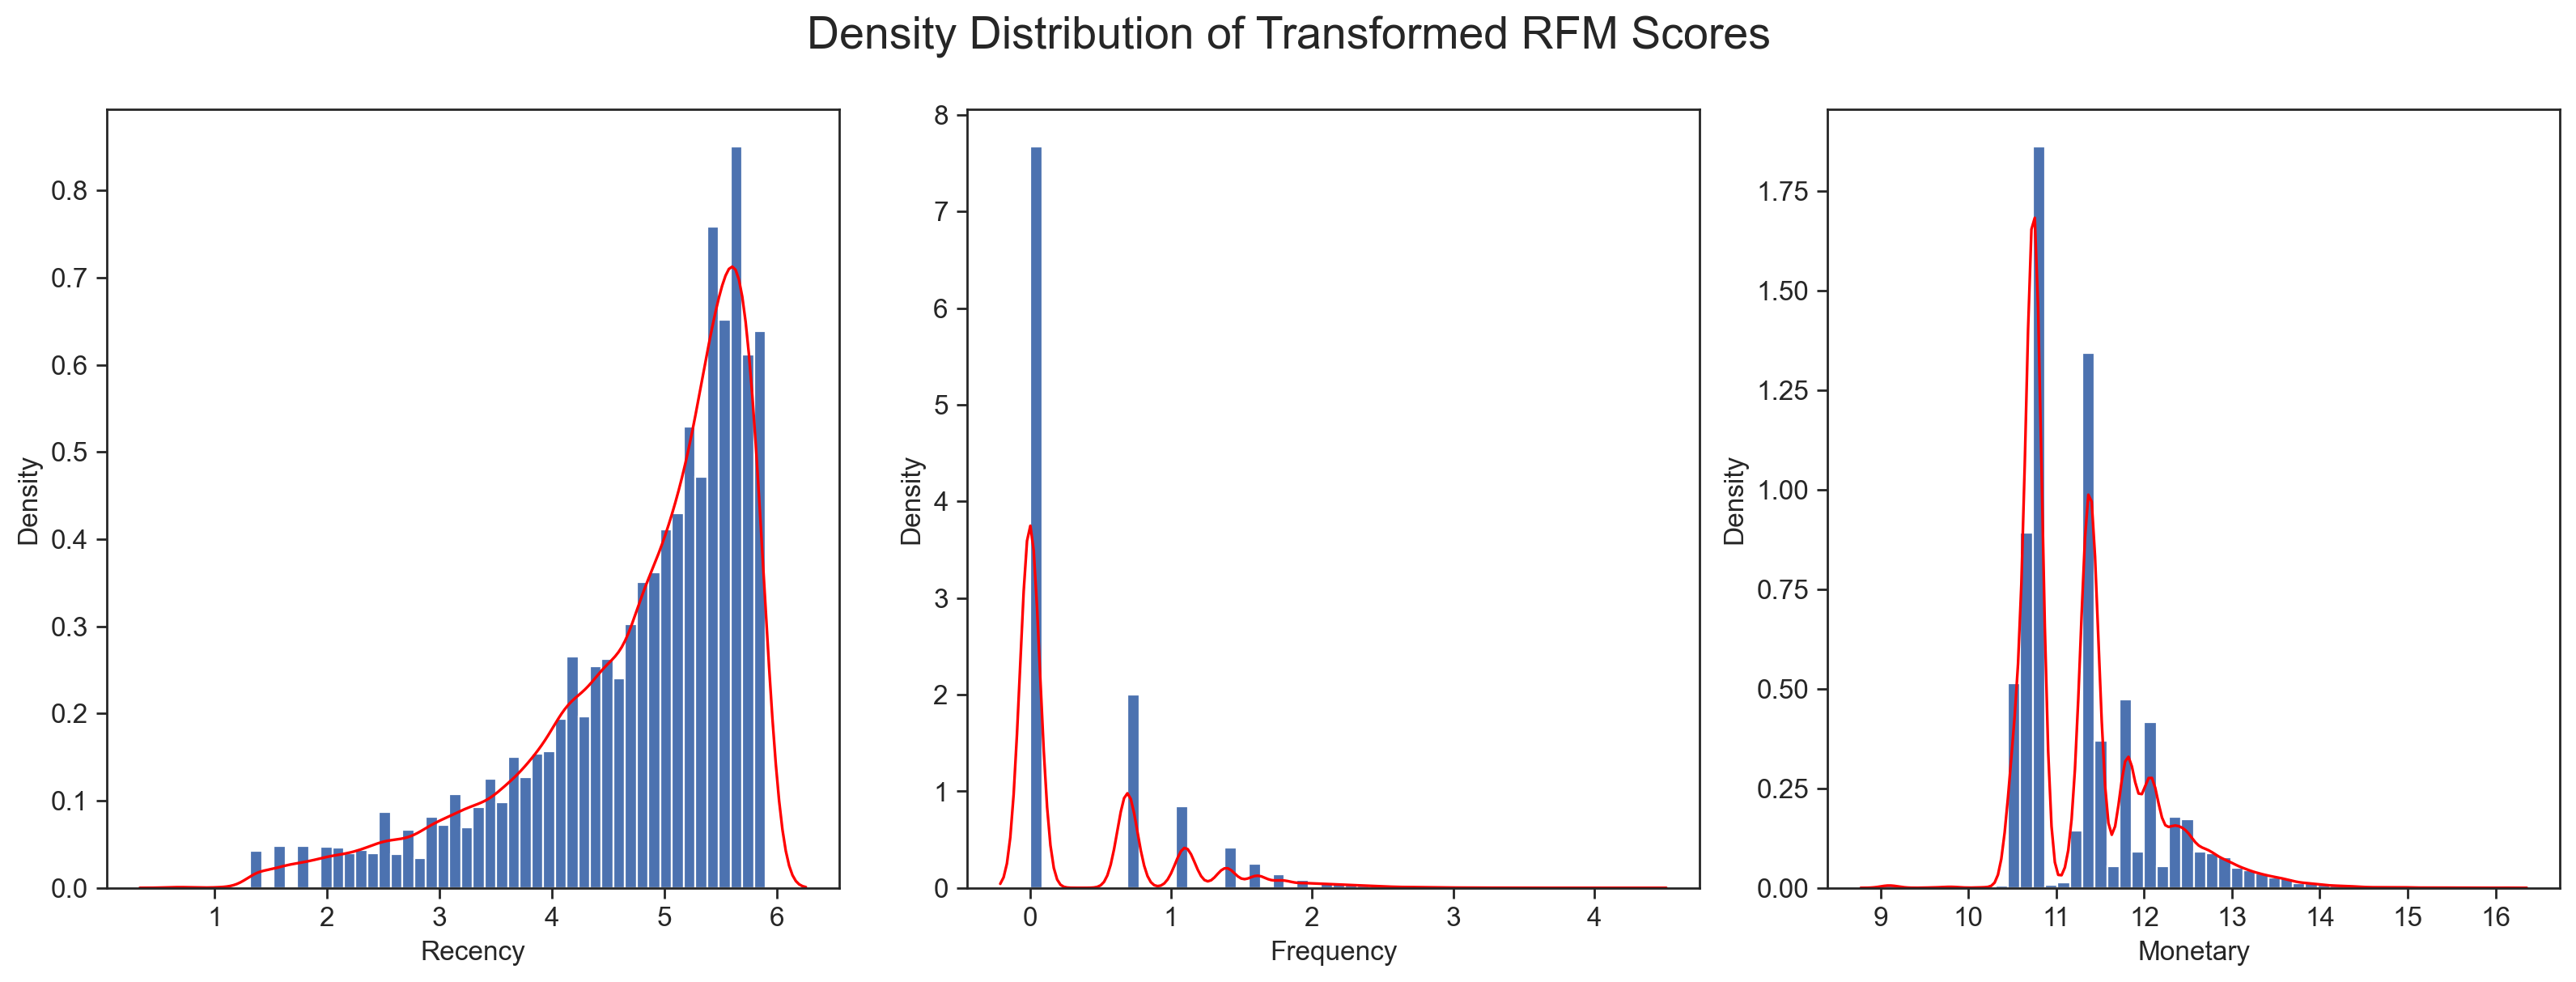

In [58]:
# plotting density distribution of the transformed RFM scores
plt.figure(figsize = (16, 6))
subplot_num = 1
for col in cols:
    if subplot_num <= len(cols):
        plt.subplot(1, 3, subplot_num)
        # to draw a kde line with a different color, histogram and density have to be drawn as seprate plots
        ax = sns.distplot(df_rfm_log[col], kde=True, hist=True, hist_kws={'alpha':1})
        ax.lines[0].set_color('red')
    subplot_num += 1
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
plt.suptitle("Density Distribution of Transformed RFM Scores", fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

Grafik distribusi recency menunjukkan skewness negatif, sementara distribusi frequency dan monetary menunjukkan skewness positif. Hal ini menggambarkan bahwa customer brand A cenderung bersifat pasif.

In [59]:
# dropping the index 'Customer_ID' as it is not needed for the analysis
df_rfm_log.reset_index(drop=True, inplace=True)

# checking if there missing values
df_rfm_log.isnull().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [60]:
# Standardizing the variables
#df_X = df_rfm_log
X = df_rfm_log.values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
df_X_scaled = pd.DataFrame(X_scaled, columns=cols)
df_X_scaled.head()

Recency  Frequency  Monetary
0 -1.282846   -0.62713 -0.784847
1 -0.713133   -0.62713 -1.057562
2 -0.936949   -0.62713 -1.057562
3 -1.120071   -0.62713 -0.812118
4 -2.534180   -0.62713 -0.784847

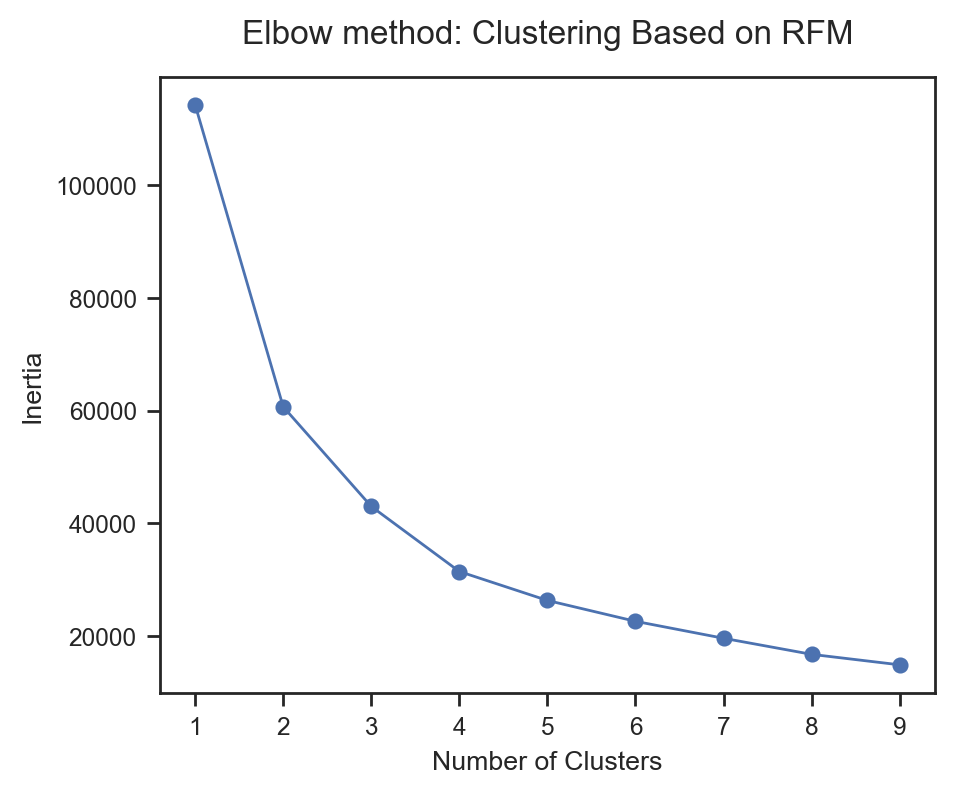

In [61]:
wcss = []
max_value = 10
for k in range(1, max_value):
    k_means = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500, random_state=42)
    k_means.fit(X_scaled)
    wcss.append(k_means.inertia_)
# plotting the wcss values
plt.figure(figsize=(5,4))
plt.plot(range(1, 10), wcss, linewidth=1.0, marker='o')
plt.title('Elbow method: Clustering Based on RFM', fontsize=12)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 10))
plt.show()

In [62]:
# determining the best number of clusters automatically
from kneed import KneeLocator
kl = KneeLocator(range(1, max_value), wcss, curve="convex", direction="decreasing")
print('Elbow Point:', kl.elbow)

Elbow Point: 3


Menurut metode elbow, jumlah klaster optimum yang dapat dibentuk adalah sebanyak 3 klaster. Selanjutnya, untuk menentukan klaster customer, akan digunakan beberapa metode, yaitu:

1.   KMeans Custering
2.   Hierarchical Clustering
3.   Gaussian Mixture Model (GMM)
4.   Spectral Clustering
5.   DBSCAN Clustering

Dari beberapa algoritma di atas, nilai silhouette score akan dibandingkan. Semakin besar nilai silhouette score, semakin baik klaster yang terbentuk.

#### KMeans Clustering

In [64]:
# defining a list for holding results of each algorithm as dataframe
models_results_list = []

# building a kmeans model with 3 clusters
model_name = 'KMeans'
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_X_scaled)
kmeans_cluster_labels = kmeans.labels_
#kmeans_cluster_centers = kmeans.cluster_centers_
print('KMeans Predicted Labels:')
kmeans_cluster_labels

KMeans Predicted Labels:


array([1, 1, 1, ..., 0, 0, 2], dtype=int32)

In [67]:
print('Unique Cluster Labels: ', np.unique(kmeans_cluster_labels))

Unique Cluster Labels:  [0 1 2]


In [68]:
# evaluating the model using silhouette_score.
# this is a coefficient value that ranges from -1 to +1. A higher silhouette score is indicative of a better model.
kmeans_sil_score = silhouette_score(df_X_scaled, kmeans_cluster_labels, metric='euclidean')
print(round(kmeans_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score":kmeans_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.442


#### Hierarchical Clustering

In [ ]:
# clustering using Hierarchical Clustering approach
model_name = 'Agglomerative Clustering'
agg_model = AgglomerativeClustering(n_clusters=3)
agg_model.fit(df_X_scaled)
agg_cluster_labels = agg_model.labels_

In [ ]:
print('Unique Cluster Labels: ', np.unique(agg_cluster_labels))

Unique Cluster Labels:  [0 1 2]


In [ ]:
# evaluating the model using silhouette_score.
# this is a coefficient value that ranges from -1 to +1. A higher silhouette score is indicative of a better model.
agg_sil_score = silhouette_score(df_X_scaled, agg_cluster_labels, metric='euclidean')
print(round(agg_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": agg_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.364


#### Gaussian Mixture Model (GMM)

In [69]:
model_name = 'Gaussian Mixture'
gmm_model = GaussianMixture(n_components=3, random_state=0)
gmm_pred_labels = gmm_model.fit_predict(df_X_scaled)

In [70]:
print('Unique Cluster Labels: ', np.unique(gmm_pred_labels))

Unique Cluster Labels:  [0 1 2]


In [71]:
# evaluating the model using silhouette_score.
gmm_sil_score = silhouette_score(df_X_scaled, gmm_pred_labels, metric='euclidean')
print(round(gmm_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": gmm_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.354


#### Spectral Clustering

In [72]:
model_name = 'Spectral Clustering'
spectral_model= SpectralClustering(n_clusters=5, random_state=0, n_neighbors=8, affinity='nearest_neighbors')
spectral_model.fit(df_X_scaled)
spectral_cluster_labels = spectral_model.labels_

In [73]:
print('Unique Cluster Labels: ', np.unique(spectral_cluster_labels))

Unique Cluster Labels:  [0 1 2 3 4]


In [74]:
# evaluating the model using silhouette_score.
spectral_sil_score = silhouette_score(df_X_scaled, spectral_cluster_labels, metric='euclidean')
print(round(spectral_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": gmm_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

-0.333


#### DBSCAN Clustering

In [75]:
model_name = 'DBSCAN'
dbs_model = DBSCAN(eps=0.25, min_samples=9)
dbs_pred_clusters = dbs_model.fit_predict(df_X_scaled)

In [76]:
print('Unique Cluster Labels: ', np.unique(dbs_pred_clusters))

Unique Cluster Labels:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [77]:
# evaluating the model using silhouette_score.
dbs_sil_score = silhouette_score(df_X_scaled, dbs_pred_clusters, metric='euclidean')
print(round(dbs_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": dbs_sil_score}, index=[model_name])

0.297


### Silhouette Score

In [78]:
# combile the models' results in a dataframe for comparison
models_results_list.append(df_model_results)
df_results = pd.concat(models_results_list, axis=0).round(3)  # appending dataframes row-wise
# convert index to xolumn and rename the columns
df_results.reset_index(inplace=True)
df_results.rename(columns={'index':'Model Name', 'silhouette_score': 'Silhouette Score'}, inplace=True)
df_results

Model Name  Silhouette Score
0               KMeans             0.442
1     Gaussian Mixture             0.354
2  Spectral Clustering             0.354
3               DBSCAN             0.297

Semakin tinggi nilai Silhouette Score, semakin baik klaster yang dihasilkan. Dari tabel diatas dapat disimpulkan bahwa algoritma KMeans menghasilkan klaster terbaik dibandingkan klaster metode lainnya.

In [ ]:
df_rfm['Cluster'] = kmeans_cluster_labels

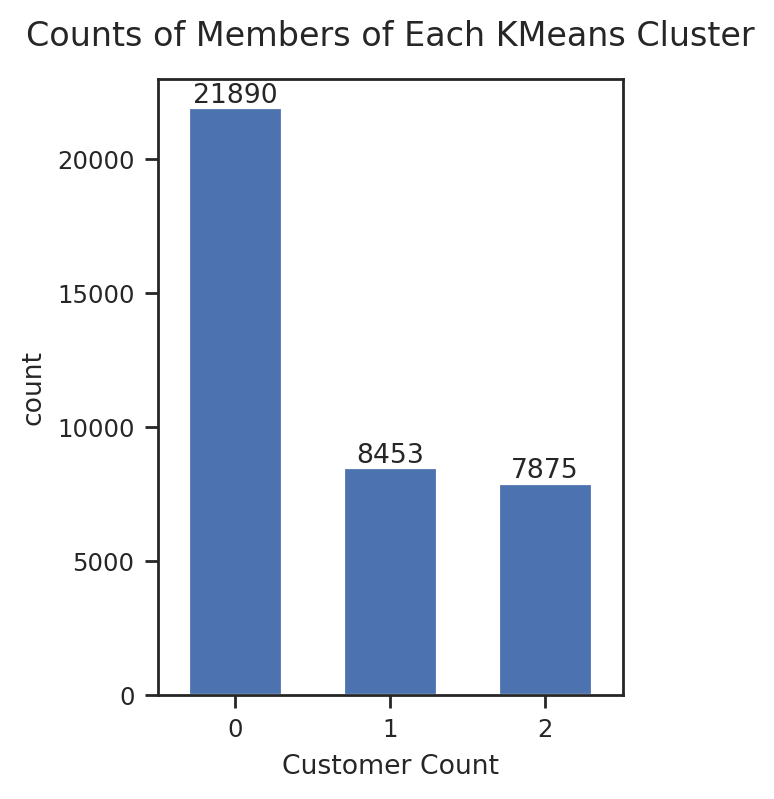

In [66]:
# plotting counts of Cluster columns
plt.figure(figsize=(3,4))
ax = sns.countplot(data=df_rfm, x='Cluster', saturation=1.0, width=0.6)
ax.bar_label(ax.containers[0])  # display figures on top of bars
plt.title('Counts of Members of Each KMeans Cluster', fontsize=12)
plt.xlabel('Cluster')
plt.xlabel('Customer Count')
plt.show()

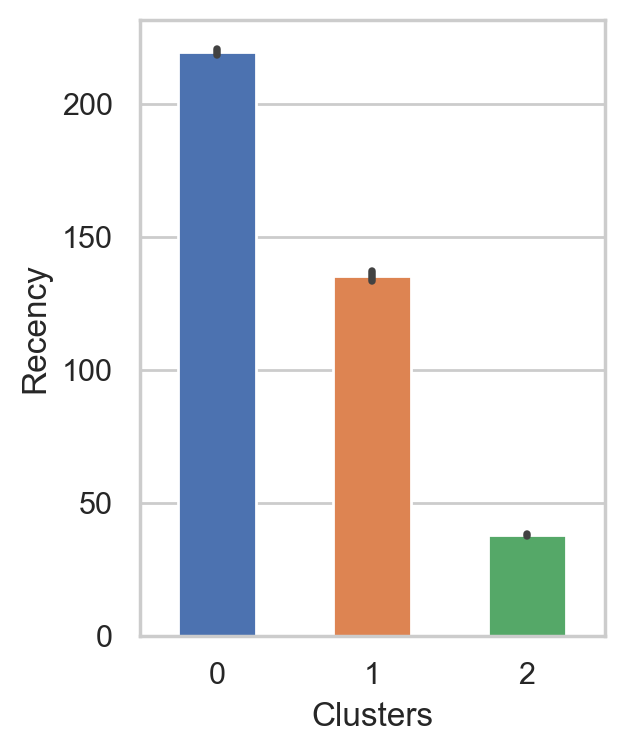

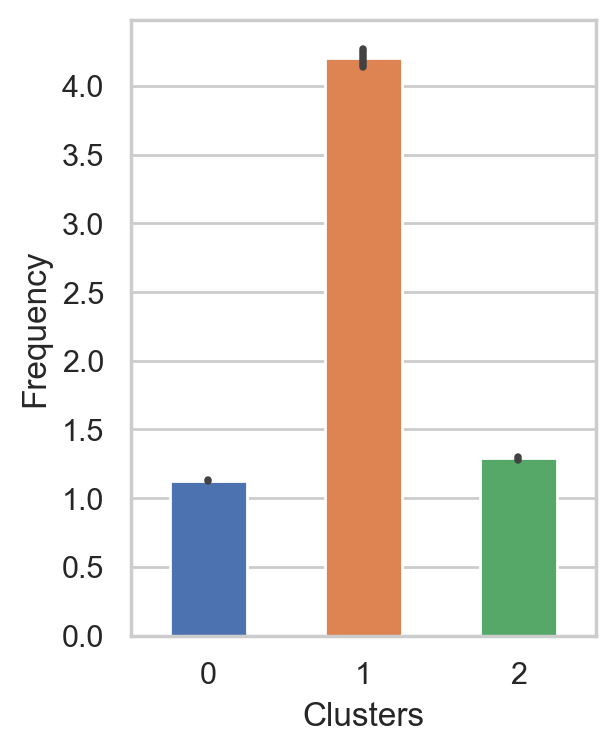

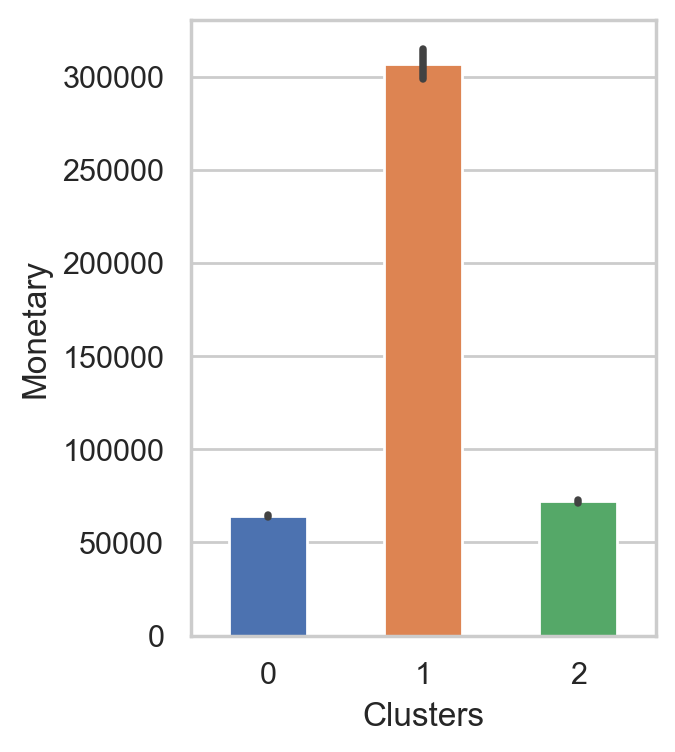

In [ ]:
# visualizing the clusters
for col in cols:
    plt.figure(figsize=(3,4))
    sns.barplot(x='Cluster', y=str(col), data=df_rfm, saturation=1.0, width=0.50)
    plt.xlabel('Clusters')
    plt.show()

In [ ]:
# Calculate RFM metrics
df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

Cluster     Recency  Frequency       Monetary
0        0  219.589777   1.126131   64167.826742
1        1  135.328254   4.200685  306910.034255
2        2   37.734436   1.288633   71991.870484

Mayoritas customer Prenagen tergolong sebagai klaster 0 (low tier customer), yaitu pelanggan yang memiliki nilai frequency dan monetary yang kecil, namun memiliki nilai recency yang tinggi.

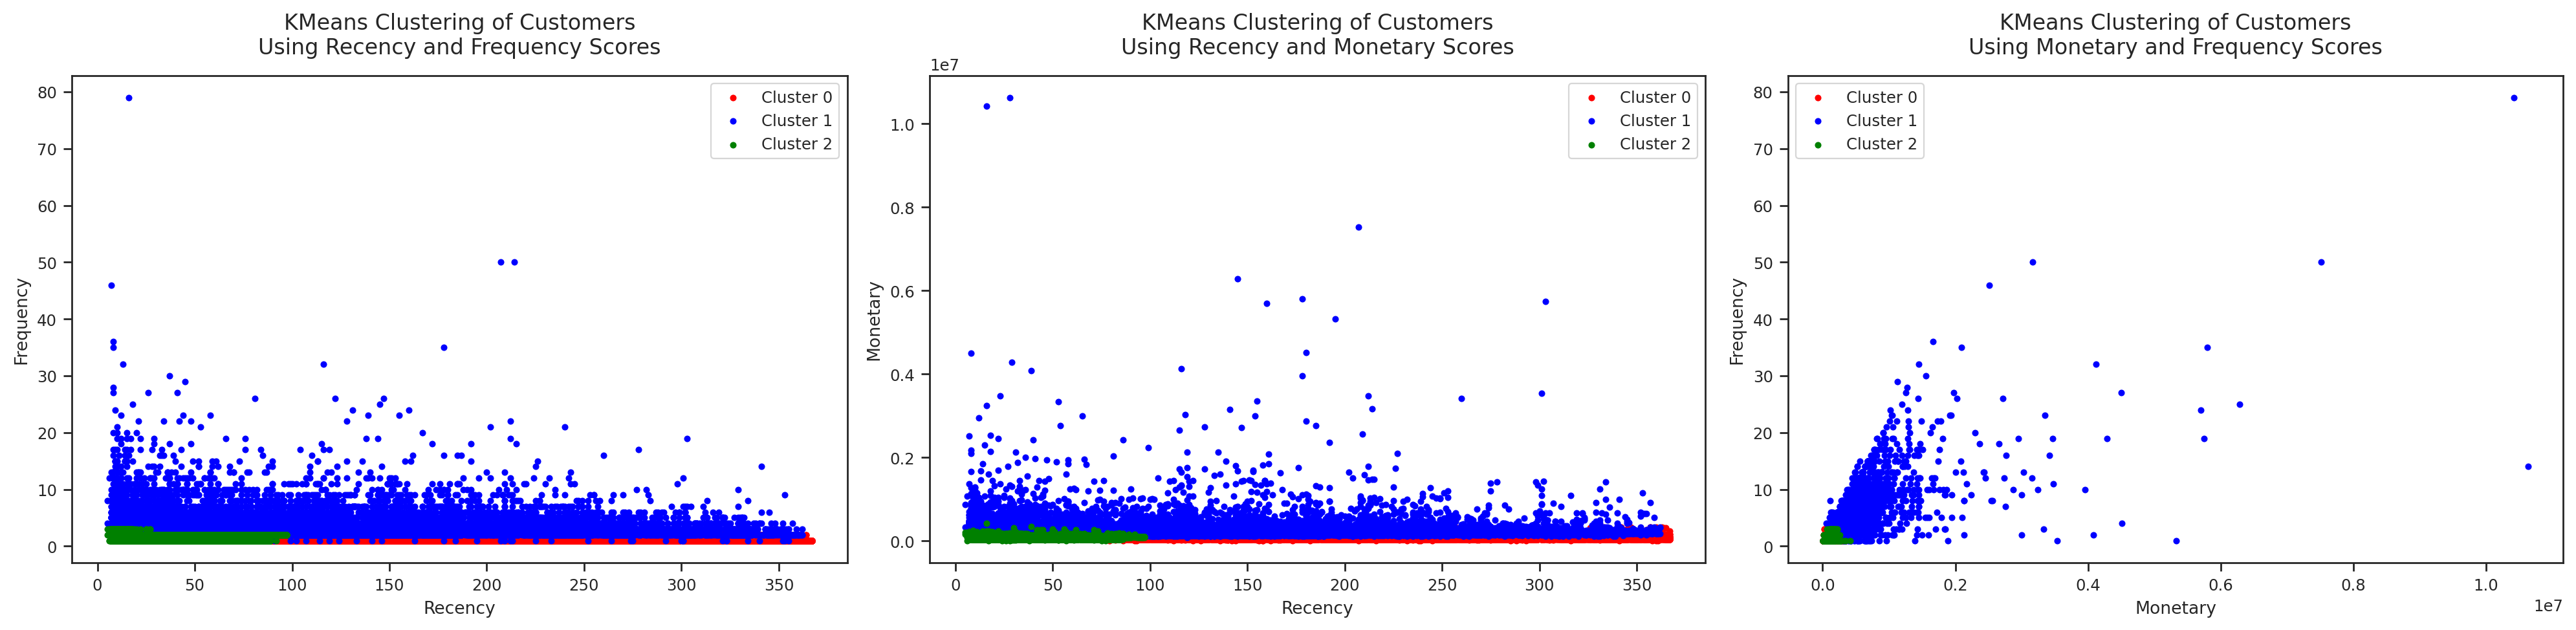

In [77]:
import matplotlib.pyplot as plt

# Set up a 1x3 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Visualizing the data in two dimensions (Recency Vs Frequency)
axs[0].scatter(df_rfm[df_rfm['Cluster']==0]['Recency'], df_rfm[df_rfm['Cluster']==0]['Frequency'], label='Cluster 0', c='red', s=8)
axs[0].scatter(df_rfm[df_rfm['Cluster']==1]['Recency'], df_rfm[df_rfm['Cluster']==1]['Frequency'], label='Cluster 1', c='blue', s=8)
axs[0].scatter(df_rfm[df_rfm['Cluster']==2]['Recency'], df_rfm[df_rfm['Cluster']==2]['Frequency'], label='Cluster 2', c='green', s=8)
axs[0].legend()
axs[0].set_xlabel('Recency')
axs[0].set_ylabel('Frequency')
axs[0].set_title('KMeans Clustering of Customers\nUsing Recency and Frequency Scores', fontsize=12)

# Visualizing the data in two dimensions (Recency Vs Monetary)
axs[1].scatter(df_rfm[df_rfm['Cluster']==0]['Recency'], df_rfm[df_rfm['Cluster']==0]['Monetary'], label='Cluster 0', c='red', s=8)
axs[1].scatter(df_rfm[df_rfm['Cluster']==1]['Recency'], df_rfm[df_rfm['Cluster']==1]['Monetary'], label='Cluster 1', c='blue', s=8)
axs[1].scatter(df_rfm[df_rfm['Cluster']==2]['Recency'], df_rfm[df_rfm['Cluster']==2]['Monetary'], label='Cluster 2', c='green', s=8)
axs[1].legend()
axs[1].set_xlabel('Recency')
axs[1].set_ylabel('Monetary')
axs[1].set_title('KMeans Clustering of Customers\nUsing Recency and Monetary Scores', fontsize=12)

# Visualizing the data in two dimensions (Monetary Vs Frequency)
axs[2].scatter(df_rfm[df_rfm['Cluster']==0]['Monetary'], df_rfm[df_rfm['Cluster']==0]['Frequency'], label='Cluster 0', c='red', s=8)
axs[2].scatter(df_rfm[df_rfm['Cluster']==1]['Monetary'], df_rfm[df_rfm['Cluster']==1]['Frequency'], label='Cluster 1', c='blue', s=8)
axs[2].scatter(df_rfm[df_rfm['Cluster']==2]['Monetary'], df_rfm[df_rfm['Cluster']==2]['Frequency'], label='Cluster 2', c='green', s=8)
axs[2].legend()
axs[2].set_xlabel('Monetary')
axs[2].set_ylabel('Frequency')
axs[2].set_title('KMeans Clustering of Customers\nUsing Monetary and Frequency Scores', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

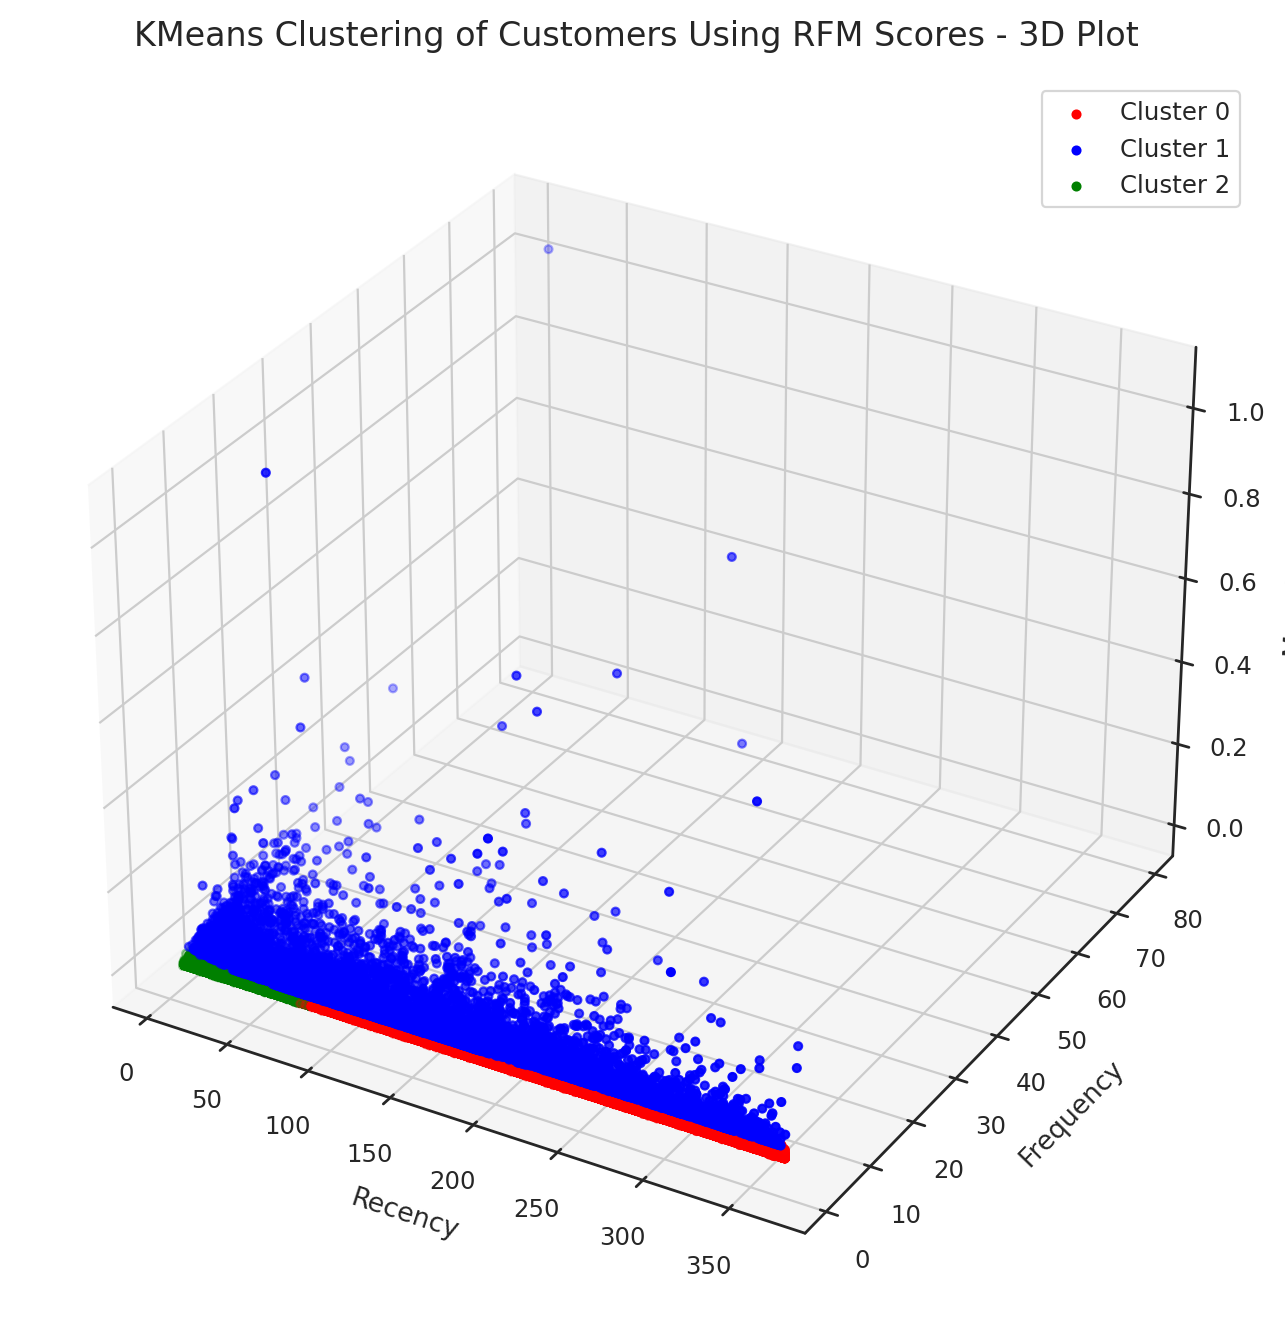

In [80]:
# Visualizing the data in 3D
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# Scatter plot for Cluster 0
ax.scatter(df_rfm[df_rfm['Cluster'] == 0]['Recency'],
           df_rfm[df_rfm['Cluster'] == 0]['Frequency'],
           df_rfm[df_rfm['Cluster'] == 0]['Monetary'],
           label='Cluster 0', c='red', s=8)

# Scatter plot for Cluster 1
ax.scatter(df_rfm[df_rfm['Cluster'] == 1]['Recency'],
           df_rfm[df_rfm['Cluster'] == 1]['Frequency'],
           df_rfm[df_rfm['Cluster'] == 1]['Monetary'],
           label='Cluster 1', c='blue', s=8)

# Scatter plot for Cluster 2
ax.scatter(df_rfm[df_rfm['Cluster'] == 2]['Recency'],
           df_rfm[df_rfm['Cluster'] == 2]['Frequency'],
           df_rfm[df_rfm['Cluster'] == 2]['Monetary'],
           label='Cluster 2', c='green', s=8)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('KMeans Clustering of Customers Using RFM Scores - 3D Plot', fontsize=12)
plt.legend()
plt.show()
#fig.savefig('D:/Roudhotul Maemanah/Portofolio/RFM/KMeans_Clustering_of_RFM_Scores.png', format='png', dpi=1200)



Hasil pengamatan dari output di atas:

1.  Klaster 0 dan 2 memiliki nilai recency yang terpisah dengan jelas, sementara untuk klaster 1 nilai frequencynya terpisah dengan jelas.

2.  Klaster 0 terdiri dari customer yang tergolong pasif (hanya mencoba) dan memiliki potensi besar untuk churn. Oleh karena itu, diperlukan strategi marketing yang bertujuan untuk mencegah customer ini agar tidak churn.

3.  Klaster 2 terdiri dari customer baru yang baru mencoba produk brand A. Hal ini dapat dilihat dari nilai recency dan frekuensi yang rendah. Oleh karena itu, diperlukan strategi marketing khusus untuk menjaga customer baru agar tetap menggunakan brand A.

4.  Klaster 1 terdiri dari customer dengan nilai frequency dan monetary yang tinggi. Oleh karena itu, diperlukan strategi marketing yang bertujuan untuk mempertahankan loyalitas customer ini dan meningkatkan interaksi mereka dengan brand A.

Reference :
[github](https://github.com/Popseli/Customer-Segmentation-Using-Cohort-RFM-and-Clustering-Analyses/blob/main/Customer%20Segmentation%20Using%20Cohort%2C%20RFM%20and%20Clustering%20Analyses.ipynb)